# Étape 1 — Définir les constantes « overview » (traduction FR)

**Objectif.** Centraliser les paramètres globaux de l’étude (croissance, main-d’œuvre, actualisation, horizon) dans un fichier unique `overview.py`.
**Remarques clés.**

* Les **taux** sont en fraction (ex. `0.02` = 2 %).
* Les **heures supplémentaires** se paient à **1,5×** le salaire de base. Comme le « 1,0× » est déjà compté dans les heures normales, on ajoute seulement la **majoration** de `0,5×` pour les heures sup (d’où `facteur_majoration_heures_sup = 0.5`).
* L’énoncé demande de comparer les options sur un **horizon de 5 ans** et d’évaluer la **VAN** pour choisir entre agrandir le stade existant ou en construire un nouveau. 


In [126]:
import pandas as pd

# 1. Forcer pandas à ne jamais afficher en notation scientifique
pd.options.display.float_format = '{:,.2f}'.format

# 2. Ajouter séparateurs d'espaces pour les grands nombres (style français)
pd.options.display.float_format = lambda x: f"{x:,.2f}".replace(",", " ")


## Étape 2 — Données Main-d'œuvre

Nous importons la feuille *Main-d'œuvre* du fichier Excel :  
- On saute les 3 premières lignes d’instructions.  
- On conserve **toutes les colonnes** (toutes sont utiles pour l’analyse).  
- On ignore la première colonne (inutile).  
- On ajoute une colonne calculée : **Salaire annuel (année 1)** en tenant compte :
  - des heures normales (heures moyennes × salaire horaire × 12),
  - des heures supplémentaires : une heure supplémentaire est payée **1,5 × le salaire horaire**.  
    Comme les **1,0 ×** sont déjà comptés dans les heures normales, on ajoute seulement **+0,5 × salaire horaire × heures sup × 12**.


In [127]:
import pandas as pd
import sys, os
sys.path.insert(0, os.path.abspath(".."))

from utils.constants import VUEDENSEMBLE

# Charger le fichier Excel (adapter le chemin si besoin)
fichier_excel = "../data/Toronto Sports Entertainment_Sept 2025_FR.xlsx"

# Lire la feuille "Main-d'oeuvre" en sautant les 3 premières lignes
df_main = pd.read_excel(fichier_excel, sheet_name="Informations - main d'oeuvre", skiprows=3)
df_main = df_main.iloc[:, 1:]  # Supprimer la première colonne vide
df_main["Option de projet d’infrastructure"] = df_main["Option de projet d’infrastructure"].replace({
    "Agrandir le TO Field": "Agrandissement du TO Field",
    "Construire un nouveau stade": "Construction d’un nouveau stade"
})

# Calcul du salaire annuel de la première année
heures_base_mois = VUEDENSEMBLE["heures_moyennes_par_mois"]
facteur_sup = VUEDENSEMBLE["facteur_majoration_heures_sup"]

df_main["Salaire annuel (année 1)"] = (
    (heures_base_mois * df_main["Salaire horaire ($)"] * 12)
    + (df_main["Heures supplémentaires/mois"] * df_main["Salaire horaire ($)"] * (1 + facteur_sup) * 12)
)

print("Constantes utilisées :")
print(f"Heures moyennes par mois = {heures_base_mois}")
print(f"Facteur de majoration heures supplémentaires = {facteur_sup}")

df_main.head()


Constantes utilisées :
Heures moyennes par mois = 130
Facteur de majoration heures supplémentaires = 0.5


,Option de projet d’infrastructure,Rôle,Niveau d'éducation,Salaire horaire ($),Heures supplémentaires/mois,Salaire annuel (année 1)
0,Construction d’un nouveau stade,Ingénieur,Maîtrise,40,1,63 120.00
1,Agrandissement du TO Field,Gestionnaire de projet,Doctorat,84,6,140 112.00
2,Construction d’un nouveau stade,Travailleur de la construction,Maîtrise,63,2,100 548.00
3,Agrandissement du TO Field,Électricien,Maîtrise,81,8,138 024.00
4,Agrandissement du TO Field,Travailleur de la construction,École secondaire,46,39,104 052.00


In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# S'assurer des bons types numériques
cols_num = ["Salaire horaire ($)", "Heures supplémentaires/mois"]
cols_num += [c for c in df_main.columns if c.startswith("Salaire annuel (année ")]
df_main[cols_num] = df_main[cols_num].apply(pd.to_numeric, errors="coerce")

# Formateur "milliers avec espaces" pour les axes
def fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
formatter = FuncFormatter(fmt_milliers)

# Petite palette de projets (ordre stable)
projets = list(df_main["Option de projet d’infrastructure"].dropna().unique())


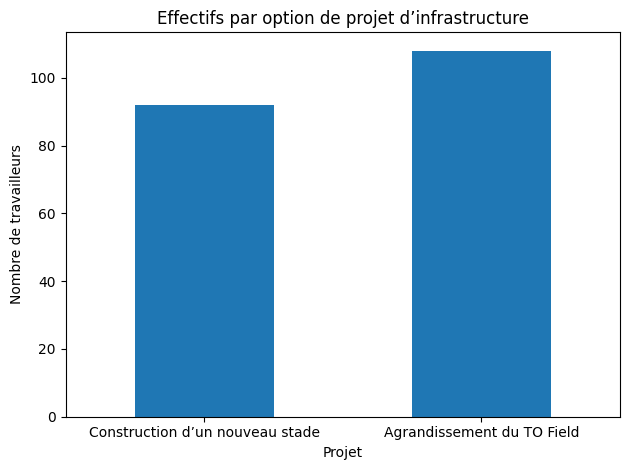

In [167]:
vc = df_main["Option de projet d’infrastructure"].value_counts().reindex(projets)

plt.figure()
vc.plot(kind="bar")
plt.title("Effectifs par option de projet d’infrastructure")
plt.xlabel("Projet")
plt.ylabel("Nombre de travailleurs")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

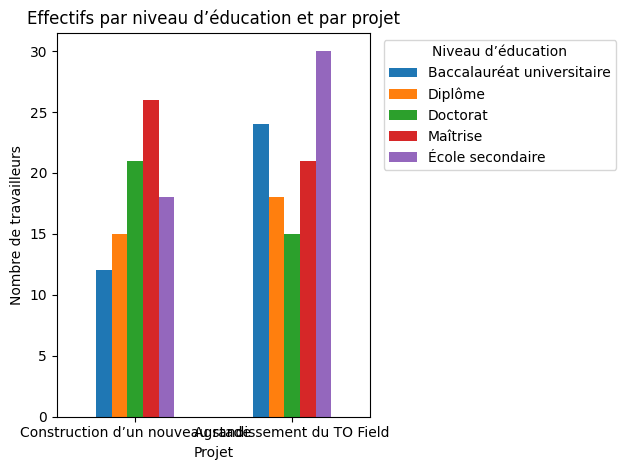

In [168]:
edu = (
    df_main
    .groupby(["Option de projet d’infrastructure", "Niveau d'éducation"])
    .size()
    .unstack(fill_value=0)
    .reindex(projets)
)

plt.figure()
edu.plot(kind="bar")
plt.title("Effectifs par niveau d’éducation et par projet")
plt.xlabel("Projet")
plt.ylabel("Nombre de travailleurs")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.legend(title="Niveau d’éducation", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


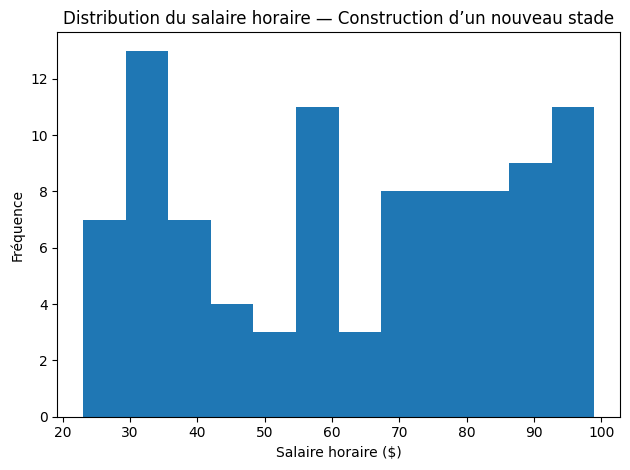

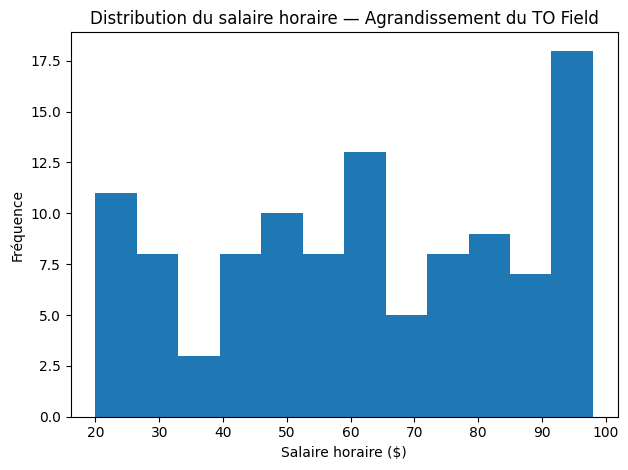

In [169]:
for p in projets:
    data = df_main.loc[df_main["Option de projet d’infrastructure"] == p, "Salaire horaire ($)"].dropna()
    plt.figure()
    plt.hist(data, bins=12)
    plt.title(f"Distribution du salaire horaire — {p}")
    plt.xlabel("Salaire horaire ($)")
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\1280334285.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=projets, showfliers=True)


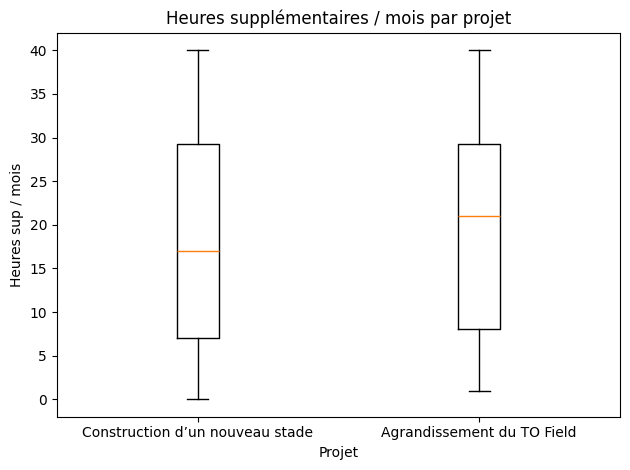

In [170]:
data_box = [df_main.loc[df_main["Option de projet d’infrastructure"] == p, "Heures supplémentaires/mois"].dropna() for p in projets]

plt.figure()
plt.boxplot(data_box, labels=projets, showfliers=True)
plt.title("Heures supplémentaires / mois par projet")
plt.xlabel("Projet")
plt.ylabel("Heures sup / mois")
plt.tight_layout()
plt.show()


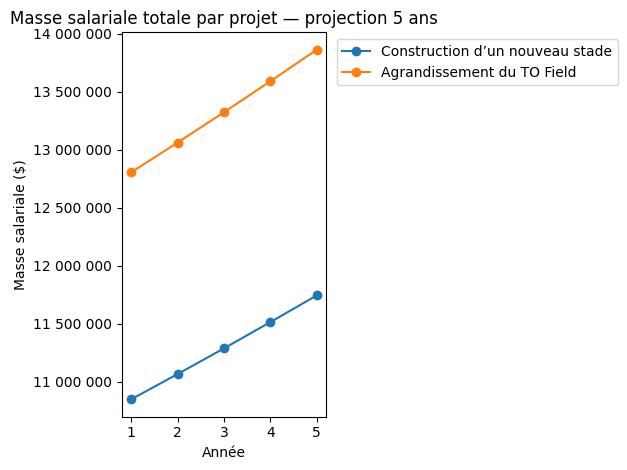

In [171]:
# Colonnes des salaires annuels (année 1..5)
cols_sal = [c for c in df_main.columns if c.startswith("Salaire annuel (année ")]
cols_sal = sorted(cols_sal, key=lambda x: int(x.split("année ")[1].rstrip(")")))

# Agrégation par projet
masse = (
    df_main.groupby("Option de projet d’infrastructure")[cols_sal]
    .sum(numeric_only=True)
    .reindex(projets)
)

# Conversion en format long pour tracer des courbes
masse_long = (
    masse
    .reset_index()
    .melt(id_vars="Option de projet d’infrastructure", var_name="Année", value_name="Masse salariale")
)
# Nettoyage des labels d'année -> 1..5
masse_long["Année_num"] = masse_long["Année"].str.extract(r"(\d+)").astype(int)

plt.figure()
for p in projets:
    sub = masse_long[masse_long["Option de projet d’infrastructure"] == p].sort_values("Année_num")
    plt.plot(sub["Année_num"], sub["Masse salariale"], marker="o", label=p)

plt.title("Masse salariale totale par projet — projection 5 ans")
plt.xlabel("Année")
plt.ylabel("Masse salariale ($)")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([1,2,3,4,5])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Étape 3 — Projection des salaires sur 5 ans

À partir du **salaire annuel (année 1)** calculé à l’étape 2 :  
- Nous appliquons le **taux de croissance des coûts** défini dans `constants.py`.  
- Pour chaque rôle, nous générons 4 nouvelles colonnes : `Salaire annuel (année 2)`, ..., `Salaire annuel (année 5)`.  
- Cela permet d’obtenir le **coût de main-d’œuvre projeté sur 5 ans**.


In [128]:
# Récupération du taux de croissance des coûts
taux_croissance = VUEDENSEMBLE["taux_croissance_couts"]

# Création des colonnes pour les années 2 à 5
for annee in range(2, VUEDENSEMBLE["duree_analyse_ans"] + 1):
    col_prec = f"Salaire annuel (année {annee-1})"
    col_nouv = f"Salaire annuel (année {annee})"
    df_main[col_nouv] = df_main[col_prec] * (1 + taux_croissance)

print(f"Taux de croissance des coûts = {taux_croissance}")

# Aperçu des 5 premières lignes
df_main.head()


Taux de croissance des coûts = 0.02


,Option de projet d’infrastructure,Rôle,Niveau d'éducation,Salaire horaire ($),Heures supplémentaires/mois,Salaire annuel (année 1),Salaire annuel (année 2),Salaire annuel (année 3),Salaire annuel (année 4),Salaire annuel (année 5)
0,Construction d’un nouveau stade,Ingénieur,Maîtrise,40,1,63 120.00,64 382.40,65 670.05,66 983.45,68 323.12
1,Agrandissement du TO Field,Gestionnaire de projet,Doctorat,84,6,140 112.00,142 914.24,145 772.52,148 687.98,151 661.73
2,Construction d’un nouveau stade,Travailleur de la construction,Maîtrise,63,2,100 548.00,102 558.96,104 610.14,106 702.34,108 836.39
3,Agrandissement du TO Field,Électricien,Maîtrise,81,8,138 024.00,140 784.48,143 600.17,146 472.17,149 401.62
4,Agrandissement du TO Field,Travailleur de la construction,École secondaire,46,39,104 052.00,106 133.04,108 255.70,110 420.81,112 629.23


## Étape 4 — Agrégation des salaires par projet

Nous regroupons les données par **option de projet d’infrastructure** :  
- Pour chaque projet (Construire un nouveau stade, Agrandir le TO Field),  
  - nous additionnons les salaires par année (année 1 à 5),  
  - nous comptons le nombre total de travailleurs associés.  

Cela permet de comparer directement l’évolution des coûts de main-d’œuvre pour les deux projets sur 5 ans.


In [129]:
# Agréger par option de projet d'infrastructure
df_salaire_projet = df_main.groupby("Option de projet d’infrastructure").agg(
    {
        "Salaire annuel (année 1)": "sum",
        "Salaire annuel (année 2)": "sum",
        "Salaire annuel (année 3)": "sum",
        "Salaire annuel (année 4)": "sum",
        "Salaire annuel (année 5)": "sum",
        "Rôle": "count"  # nombre de travailleurs
    }
)

# Renommer la colonne "Rôle" pour plus de clarté
df_salaire_projet = df_salaire_projet.rename(columns={"Rôle": "Nombre de travailleurs"})

df_salaire_projet


,Salaire annuel (année 1),Salaire annuel (année 2),Salaire annuel (année 3),Salaire annuel (année 4),Salaire annuel (année 5),Nombre de travailleurs
Option de projet d’infrastructure,,,,,,
Agrandissement du TO Field,12 804 216.00,13 060 300.32,13 321 506.33,13 587 936.45,13 859 695.18,108
Construction d’un nouveau stade,10 848 822.00,11 065 798.44,11 287 114.41,11 512 856.70,11 743 113.83,92


In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assure les bons types
cols_annees = [f"Salaire annuel (année {i})" for i in range(1, 6)]
df_salaire_projet[cols_annees + ["Nombre de travailleurs"]] = (
    df_salaire_projet[cols_annees + ["Nombre de travailleurs"]]
    .apply(pd.to_numeric, errors="coerce")
)

# Formateur "milliers avec espaces" pour les axes
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

projets = df_salaire_projet.index.tolist()


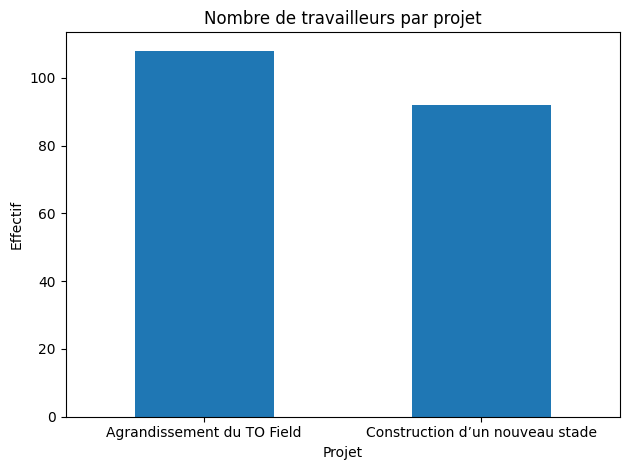

In [173]:
plt.figure()
df_salaire_projet["Nombre de travailleurs"].reindex(projets).plot(kind="bar")
plt.title("Nombre de travailleurs par projet")
plt.xlabel("Projet")
plt.ylabel("Effectif")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


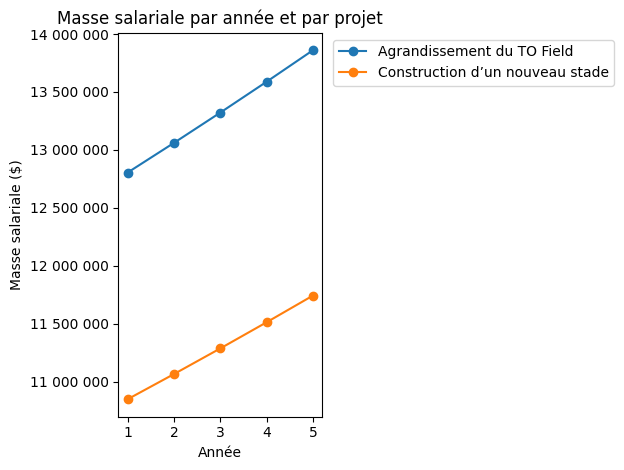

In [174]:
# Passage en long pour tracer année 1→5
tmp = (
    df_salaire_projet[cols_annees]
    .assign(Projet=df_salaire_projet.index)
    .melt(id_vars="Projet", var_name="Année", value_name="Masse")
)
tmp["Année_num"] = tmp["Année"].str.extract(r"(\d+)").astype(int)

plt.figure()
for p in projets:
    sub = tmp[tmp["Projet"] == p].sort_values("Année_num")
    plt.plot(sub["Année_num"], sub["Masse"], marker="o", label=p)

plt.title("Masse salariale par année et par projet")
plt.xlabel("Année")
plt.ylabel("Masse salariale ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks([1,2,3,4,5])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


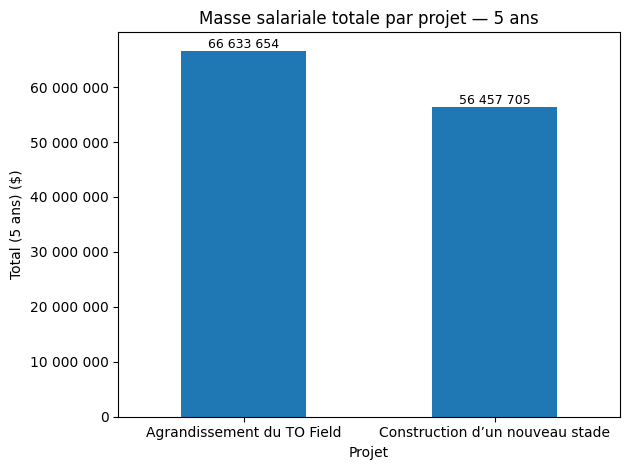

In [175]:
df_plot = df_salaire_projet.copy()
df_plot["Total (5 ans)"] = df_plot[cols_annees].sum(axis=1)

plt.figure()
ax = df_plot["Total (5 ans)"].reindex(projets).plot(kind="bar")
plt.title("Masse salariale totale par projet — 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# petites étiquettes au-dessus des barres
for i, v in enumerate(df_plot["Total (5 ans)"].reindex(projets).values):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


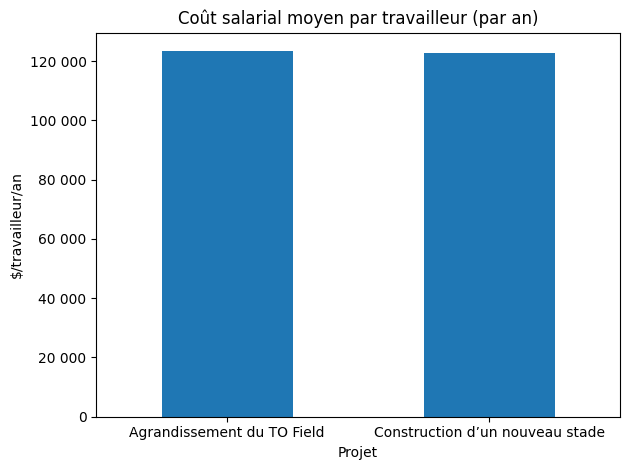

In [176]:
df_plot = df_salaire_projet.copy()
df_plot["Total (5 ans)"] = df_plot[cols_annees].sum(axis=1)
df_plot["Moyenne annuelle par travailleur"] = df_plot["Total (5 ans)"] / 5 / df_plot["Nombre de travailleurs"]

plt.figure()
df_plot["Moyenne annuelle par travailleur"].reindex(projets).plot(kind="bar")
plt.title("Coût salarial moyen par travailleur (par an)")
plt.xlabel("Projet")
plt.ylabel("$/travailleur/an")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 📒 Conclusion Étape 4 — Main-d’œuvre (salaires)

Sur 5 ans :

* **Agrandissement du TO Field** : environ **13,8 M$ par an** de salaires en fin de période, pour **108 travailleurs**.
* **Construction d’un nouveau stade** : environ **11,7 M$ par an** en fin de période, pour **92 travailleurs**.

👉 Conclusion : l’agrandissement mobilise **davantage de main-d’œuvre (+16 personnes)** et coûte plus cher en salaires, mais le nouveau stade a une masse salariale plus contenue malgré des salaires unitaires plus élevés. Cela peut se traduire par une structure plus légère en exploitation.

## Étape 5 — Coûts de construction

Nous importons la feuille *Coûts de construction* du fichier Excel :  
- On saute les 3 premières lignes d’instructions.  
- On conserve toutes les colonnes.  
- Pour chaque option de projet (Construire un nouveau stade, Agrandir le TO Field),  
  - nous identifions les **coûts de construction** initiaux,  
  - nous préparons une projection sur 5 ans (si applicable, en appliquant le taux de croissance des coûts).  

Cette étape est cruciale, car les coûts de construction représentent une **dépense majeure initiale** qui impacte directement la VAN.  
Ces chiffres, combinés avec les coûts de main-d’œuvre et les revenus futurs, permettront d’évaluer la rentabilité relative des deux options.


In [130]:
# Lecture de la feuille "Construction" en sautant les 3 premières lignes
df_construction = pd.read_excel(fichier_excel, sheet_name="Coûts de construction", skiprows=3)
df_construction = df_construction.iloc[:, 1:]  # Supprimer la première colonne vide

# Conversion en float pour forcer l'affichage avec séparateurs d'espaces
df_construction = df_construction.astype(float, errors="ignore")

# Aperçu pour vérifier les colonnes
print("Aperçu des coûts de construction :")
display(df_construction.head())

Aperçu des coûts de construction :


,Option de projet d’infrastructure,Coût d’achat du terrain,Coûts de permis et d’inspection du site,Coûts de préparation du site,Coûts annuels d’entretien,Coûts annuels de location d’équipement,Coûts mensuels de fournitures et matériaux,Coûts mensuels des services publics,Part mensuelle des revenus partagés avec les sponsors
0,Agrandissement du TO Field,25 000 000.00,29 000.00,131 000.00,500 000.00,76 000.00,55 000.00,32 000.00,20 000.00
1,Construction d’un nouveau stade,343 000 000.00,69 000.00,428 000.00,630 000.00,103 000.00,119 000.00,32 000.00,10 000.00


## Étape 5.1 — Analyse et insights des coûts de construction

À partir du tableau projeté (Année 0 → Année 5), nous ajoutons deux enrichissements :  

1. **Total (0-5 ans)** : somme des coûts sur toute la période d’analyse.  
2. **% du coût initial sur le total** : mesure du poids des coûts upfront dans le projet.  

### Conclusions possibles
- Un pourcentage élevé signifie un projet très **capitalistique** avec un risque initial important.  
- Un pourcentage plus faible signifie que le projet est **plus étalé dans le temps**, mais avec des charges récurrentes plus importantes.  
Ces différences structurent la manière dont les projets impactent la trésorerie et la prise de risque, et constituent des arguments dans le choix final.


In [131]:
taux_croissance = VUEDENSEMBLE["taux_croissance_couts"]

# Colonnes
col_uniques = ["Coût d’achat du terrain", "Coûts de permis et d’inspection du site", "Coûts de préparation du site"]
col_annuels = ["Coûts annuels d’entretien", "Coûts annuels de location d’équipement"]
col_mensuels = ["Coûts mensuels de fournitures et matériaux", "Coûts mensuels des services publics", "Part mensuelle des revenus partagés avec les sponsors"]

# DataFrame de projection avec même index et colonnes claires
df_construction_proj = pd.DataFrame(index=df_construction["Option de projet d’infrastructure"].values)

# Année 0 : seulement les coûts uniques
df_construction_proj["Année 0"] = df_construction[col_uniques].sum(axis=1).values

# Années 1 à 5
for annee in range(1, VUEDENSEMBLE["duree_analyse_ans"] + 1):
    facteur = (1 + taux_croissance) ** (annee - 1)
    couts_annuels = df_construction[col_annuels].sum(axis=1).values * facteur
    couts_mensuels = df_construction[col_mensuels].sum(axis=1).values * 12 * facteur
    df_construction_proj[f"Année {annee}"] = couts_annuels + couts_mensuels

df_construction_proj["Total (0-5 ans)"] = df_construction_proj.sum(axis=1)
df_construction_proj["% coût initial sur total"] = (
    df_construction_proj["Année 0"] / df_construction_proj["Total (0-5 ans)"] * 100
)
df_construction_proj = df_construction_proj.astype(float)
df_construction_proj


,Année 0,Année 1,Année 2,Année 3,Année 4,Année 5,Total (0-5 ans),% coût initial sur total
Agrandissement du TO Field,25 160 000.00,1 860 000.00,1 897 200.00,1 935 144.00,1 973 846.88,2 013 323.82,34 839 514.70,72.22
Construction d’un nouveau stade,343 497 000.00,2 665 000.00,2 718 300.00,2 772 666.00,2 828 119.32,2 884 681.71,357 365 767.03,96.12


In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Colonnes (mêmes noms que ta feuille Excel)
col_uniques = [
    "Coût d’achat du terrain",
    "Coûts de permis et d’inspection du site",
    "Coûts de préparation du site",
]
col_annuels = [
    "Coûts annuels d’entretien",
    "Coûts annuels de location d’équipement",
]
col_mensuels = [
    "Coûts mensuels de fournitures et matériaux",
    "Coûts mensuels des services publics",
    "Part mensuelle des revenus partagés avec les sponsors",
]

# Types numériques pour éviter les surprises
for cols in [col_uniques, col_annuels, col_mensuels]:
    df_construction[cols] = df_construction[cols].apply(pd.to_numeric, errors="coerce")

# Formatter "milliers avec espaces"
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Ordre des projets (depuis la projection)
projets = df_construction_proj.index.tolist()

# Récup du taux de croissance (pour 5.5 si besoin)
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS
gc = PARAMS["taux_croissance_couts"]


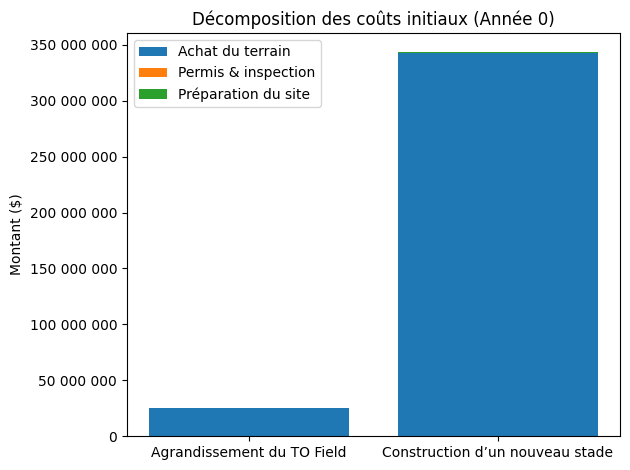

In [179]:
# Préparer les segments par projet
x = np.arange(len(projets))
h_terrain = df_construction.set_index("Option de projet d’infrastructure").loc[projets, "Coût d’achat du terrain"].values
h_permis  = df_construction.set_index("Option de projet d’infrastructure").loc[projets, "Coûts de permis et d’inspection du site"].values
h_prep    = df_construction.set_index("Option de projet d’infrastructure").loc[projets, "Coûts de préparation du site"].values

plt.figure()
b1 = plt.bar(x, h_terrain, label="Achat du terrain")
b2 = plt.bar(x, h_permis, bottom=h_terrain, label="Permis & inspection")
b3 = plt.bar(x, h_prep, bottom=h_terrain + h_permis, label="Préparation du site")

plt.title("Décomposition des coûts initiaux (Année 0)")
plt.xticks(x, projets, rotation=0)
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.legend()
plt.tight_layout()
plt.show()


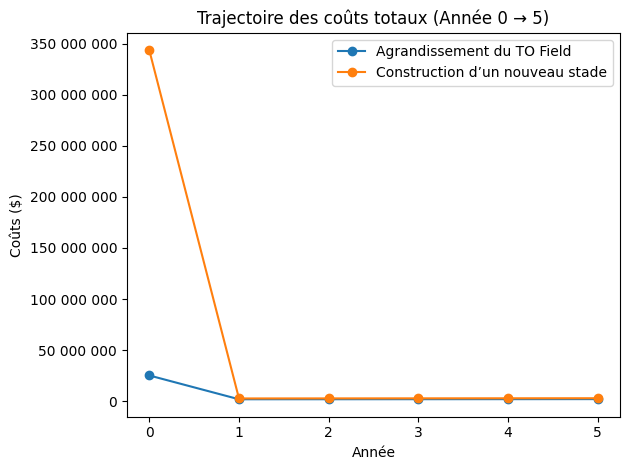

In [180]:
# Colonnes année
cols_annees = [c for c in df_construction_proj.columns if c.startswith("Année ")]
cols_annees_sorted = sorted(cols_annees, key=lambda s: int(s.split(" ")[1]))

plt.figure()
for p in projets:
    serie = df_construction_proj.loc[p, cols_annees_sorted]
    xs = [int(c.split(" ")[1]) for c in cols_annees_sorted]
    plt.plot(xs, serie.values, marker="o", label=p)

plt.title("Trajectoire des coûts totaux (Année 0 → 5)")
plt.xlabel("Année")
plt.ylabel("Coûts ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks([0,1,2,3,4,5])
plt.legend()
plt.tight_layout()
plt.show()


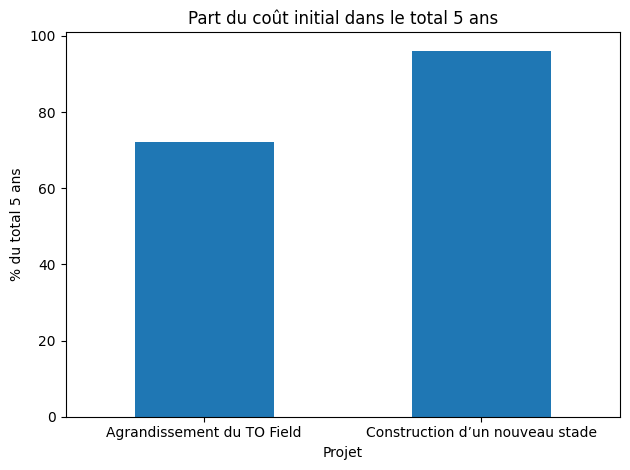

In [181]:
totaux_5ans = df_construction_proj[cols_annees_sorted].sum(axis=1)
part_init = (df_construction_proj["Année 0"] / totaux_5ans * 100).rename("Part initiale (%)")

plt.figure()
part_init.reindex(projets).plot(kind="bar")
plt.title("Part du coût initial dans le total 5 ans")
plt.xlabel("Projet")
plt.ylabel("% du total 5 ans")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


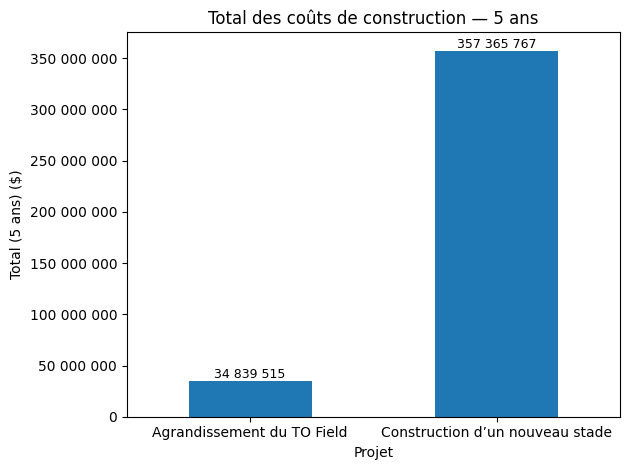

In [182]:
df_tot = pd.DataFrame({"Total (5 ans)": totaux_5ans}).reindex(projets)

plt.figure()
ax = df_tot["Total (5 ans)"].plot(kind="bar")
plt.title("Total des coûts de construction — 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# labels au-dessus des barres
vals = df_tot["Total (5 ans)"].values
for i, v in enumerate(vals):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


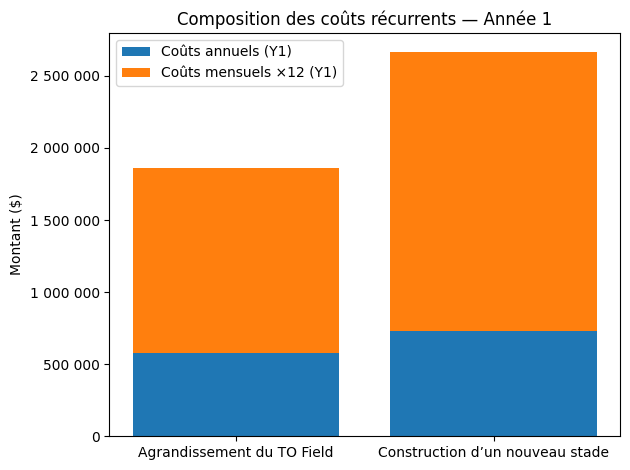

In [185]:
# Année 1 (facteur de croissance = 1)
annuels_y1  = df_construction.set_index("Option de projet d’infrastructure")[col_annuels].sum(axis=1).loc[projets].astype(float).values
mensuels_y1 = (df_construction.set_index("Option de projet d’infrastructure")[col_mensuels].sum(axis=1).loc[projets] * 12).astype(float).values

x = np.arange(len(projets))
plt.figure()
b1 = plt.bar(x, annuels_y1, label="Coûts annuels (Y1)")
b2 = plt.bar(x, mensuels_y1, bottom=annuels_y1, label="Coûts mensuels ×12 (Y1)")

plt.title("Composition des coûts récurrents — Année 1")
plt.xticks(x, projets, rotation=0)
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.legend()
plt.tight_layout()
plt.show()


## 📒 Conclusion Étape 5.1 — Coûts de construction

Sur la période de 5 ans (y compris les coûts initiaux) :

* **Agrandissement du TO Field** : environ **34,8 M$**, dont **72 % en coût initial**.
* **Construction d’un nouveau stade** : environ **357 M$**, dont **96 % en coût initial**.

👉 Conclusion : le nouveau stade est **10 fois plus cher** et extrêmement **capitalistique** (quasi tout payé dès l’an 0).
L’agrandissement, bien que beaucoup moins coûteux, conserve une part significative de frais récurrents (entretien, services, fournitures) mais reste beaucoup plus léger sur la trésorerie initiale.

## Étape 6 — Lecture des revenus

Nous importons la feuille *Revenus* du fichier Excel :  
- On saute les 3 premières lignes d’instructions.  
- On supprime la première colonne inutile (colonne vide).  
- On affiche un aperçu des données brutes pour vérifier la structure et les colonnes disponibles.  

Cette étape sert uniquement à **explorer et valider la table des revenus**, avant de passer à l’étape 6.1 où nous ferons les projections et les analyses.


In [132]:
# Lecture de la feuille "Revenus" en sautant les 3 premières lignes
df_revenus = pd.read_excel(fichier_excel, sheet_name="Revenus", skiprows=3)
df_revenus = df_revenus.iloc[:, 1:]  # Supprimer la première colonne vide

# Conversion en float pour forcer l'affichage avec séparateurs d'espaces
df_revenus = df_revenus.astype(float, errors="ignore")

# Aperçu des revenus
print("Aperçu des revenus :")
display(df_revenus.head())


Aperçu des revenus :


,Option de projet d’infrastructure,Revenus annuels de la billetterie ($),Revenus annuels de sponsoring ($),Revenus annuels des concessions ($),Ventes annuelles de marchandises ($)
0,Agrandissement du TO Field,1 335 800.00,2 954 470.00,420 660.00,166 110.00
1,Construction d’un nouveau stade,2 070 110.00,2 822 390.00,321 600.00,798 950.00


## Étape 6.1 — Projection et analyse des revenus

À partir des revenus de base (année 1), nous projetons les revenus sur 5 ans :  
- Une croissance annuelle de **15 %** est appliquée.  
- On calcule le **Total cumulé (5 ans)**.  
- On décompose les revenus par catégorie pour analyser leur poids relatif (%).  

### Conclusions possibles
- Identifier quelle source de revenus est dominante (ex. sponsoring vs billetterie).  
- Comprendre si un projet est plus dépendant d’une source de revenus spécifique (risque de concentration).  
- Comparer la dynamique de croissance entre les deux projets.


In [133]:
from IPython.display import display

# Colonnes des catégories de revenus
colonnes_revenus = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)"
]

# Dictionnaire pour stocker les tableaux séparés
projets_revenus = {}

for idx, row in df_revenus.iterrows():
    projet = row["Option de projet d’infrastructure"]
    data = {}

    # Projection année par année
    for col in colonnes_revenus:
        data[col] = [
            row[col] * (1 + taux_revenus) ** (annee - 1)
            for annee in range(1, VUEDENSEMBLE["duree_analyse_ans"] + 1)
        ]
    
    # Créer un DataFrame avec Année 1 → 5
    df_proj = pd.DataFrame(data, index=[f"Année {i}" for i in range(1, 6)])
    
    # Ajouter total cumulé par catégorie
    df_proj.loc["Total (5 ans)"] = df_proj.sum()
    
    # Ajouter % catégorie (Année 1)
    part_totale = df_proj.loc["Année 1"].sum()
    for col in colonnes_revenus:
        df_proj[f"% {col} (Année 1)"] = (df_proj.loc["Année 1", col] / part_totale) * 100
    
    projets_revenus[projet] = df_proj

print("Agrandissement du TO Field")
display(projets_revenus["Agrandissement du TO Field"])

print("Construction d’un nouveau stade")
display(projets_revenus["Construction d’un nouveau stade"])



Agrandissement du TO Field


,Revenus annuels de la billetterie ($),Revenus annuels de sponsoring ($),Revenus annuels des concessions ($),Ventes annuelles de marchandises ($),% Revenus annuels de la billetterie ($) (Année 1),% Revenus annuels de sponsoring ($) (Année 1),% Revenus annuels des concessions ($) (Année 1),% Ventes annuelles de marchandises ($) (Année 1)
Année 1,1 335 800.00,2 954 470.00,420 660.00,166 110.00,27.39,60.58,8.63,3.41
Année 2,1 536 170.00,3 397 640.50,483 759.00,191 026.50,27.39,60.58,8.63,3.41
Année 3,1 766 595.50,3 907 286.57,556 322.85,219 680.47,27.39,60.58,8.63,3.41
Année 4,2 031 584.82,4 493 379.56,639 771.28,252 632.55,27.39,60.58,8.63,3.41
Année 5,2 336 322.55,5 167 386.50,735 736.97,290 527.43,27.39,60.58,8.63,3.41
Total (5 ans),9 006 472.87,19 920 163.13,2 836 250.10,1 119 976.95,27.39,60.58,8.63,3.41


Construction d’un nouveau stade


,Revenus annuels de la billetterie ($),Revenus annuels de sponsoring ($),Revenus annuels des concessions ($),Ventes annuelles de marchandises ($),% Revenus annuels de la billetterie ($) (Année 1),% Revenus annuels de sponsoring ($) (Année 1),% Revenus annuels des concessions ($) (Année 1),% Ventes annuelles de marchandises ($) (Année 1)
Année 1,2 070 110.00,2 822 390.00,321 600.00,798 950.00,34.43,46.94,5.35,13.29
Année 2,2 380 626.50,3 245 748.50,369 840.00,918 792.50,34.43,46.94,5.35,13.29
Année 3,2 737 720.47,3 732 610.77,425 316.00,1 056 611.37,34.43,46.94,5.35,13.29
Année 4,3 148 378.55,4 292 502.39,489 113.40,1 215 103.08,34.43,46.94,5.35,13.29
Année 5,3 620 635.33,4 936 377.75,562 480.41,1 397 368.54,34.43,46.94,5.35,13.29
Total (5 ans),13 957 470.85,19 029 629.42,2 168 349.81,5 386 825.50,34.43,46.94,5.35,13.29


## 📒 Conclusion Étape 6.1 — Structure des revenus (par catégorie)

On observe que la **répartition des revenus reste constante** au fil des années, car toutes les catégories croissent au même rythme (+15 % par an).

* Pour l’**Agrandissement du TO Field**, les revenus dépendent surtout du **sponsoring (≈ 60 %)**, suivi de la billetterie (~27 %).
* Pour la **Construction d’un nouveau stade**, les revenus sont plus **diversifiés**, avec une billetterie plus importante (~34 %), un sponsoring moins dominant (~47 %), et une part significative des ventes de marchandises (~13 %).

👉 Conclusion : le nouveau stade offre une structure de revenus plus équilibrée et moins dépendante du sponsoring, ce qui peut être un atout stratégique en termes de résilience.

## Étape 6.2 — Tableau comparatif des revenus totaux

Nous construisons un tableau résumé par projet :  
- **Total cumulé (5 ans)** de tous les revenus  
- **Moyenne annuelle**  
- **Revenu par travailleur (5 ans)** (en lien avec l’étape 4)

### Intérêt
- Ce tableau offre une vision synthétique et directement comparable des deux projets.  
- Il permet d’argumenter plus facilement : ex. "le nouveau stade génère X % de plus de revenus totaux", ou "il est 20 % plus productif par travailleur".


In [134]:
# Recalculer le total cumulé 5 ans pour chaque projet
revenus_totaux = {}

for projet, df_proj in projets_revenus.items():
    total_revenus = df_proj.loc["Total (5 ans)", colonnes_revenus].sum()
    revenus_totaux[projet] = {
        "Total (5 ans)": total_revenus,
        "Moyenne annuelle": total_revenus / VUEDENSEMBLE["duree_analyse_ans"],
    }

# Transformer en DataFrame
df_revenus_total = pd.DataFrame(revenus_totaux).T

print(df_revenus_total.index)
print(df_salaire_projet.index)

# Ajouter revenu par travailleur (en utilisant df_salaire_projet de l’étape 4)
df_revenus_total["Revenu par travailleur (5 ans)"] = (
    df_revenus_total["Total (5 ans)"] / df_salaire_projet["Nombre de travailleurs"]
)

df_revenus_total


Index(['Agrandissement du TO Field', 'Construction d’un nouveau stade'], dtype='object')
Index(['Agrandissement du TO Field', 'Construction d’un nouveau stade'], dtype='object', name='Option de projet d’infrastructure')


,Total (5 ans),Moyenne annuelle,Revenu par travailleur (5 ans)
Agrandissement du TO Field,32 882 863.05,6 576 572.61,304 470.95
Construction d’un nouveau stade,40 542 275.58,8 108 455.12,440 676.91


## 📒 Conclusion Étape 6.2 — Totaux et productivité

Sur la période de 5 ans :

* **Agrandissement du TO Field** génère environ **32,9 M$** de revenus, soit une moyenne de **6,6 M$/an**, avec une productivité d’environ **304 k$/travailleur**.
* **Construction d’un nouveau stade** génère environ **40,5 M$**, soit **8,1 M$/an**, avec une productivité bien plus élevée : **441 k$/travailleur**.

👉 Conclusion : en termes absolus et relatifs, le nouveau stade surpasse l’agrandissement, tant en revenus totaux qu’en productivité par travailleur.

## Étape 6.3 — Comparatif des revenus entre les projets

Nous résumons les résultats des étapes précédentes dans un tableau comparatif.  
Pour chaque projet, nous affichons :  
- Le total des revenus sur 5 ans  
- La moyenne annuelle  
- Le revenu par travailleur  
- La différence relative entre les deux projets (%)

### Conclusions possibles
- Le nouveau stade génère **plus de revenus totaux** (+23 % environ).  
- Il est aussi **plus productif par travailleur** (+45 %).  
- L’agrandissement reste une option plus modeste, mais il s’appuie sur plus de travailleurs pour générer ses revenus.


In [135]:
# Comparatif résumé entre les deux projets
df_comparatif_revenus = df_revenus_total.copy()

# Calcul des différences relatives (en %)
diff_total = (
    (df_comparatif_revenus.loc["Construction d’un nouveau stade", "Total (5 ans)"] /
     df_comparatif_revenus.loc["Agrandissement du TO Field", "Total (5 ans)"] - 1) * 100
)

diff_travailleur = (
    (df_comparatif_revenus.loc["Construction d’un nouveau stade", "Revenu par travailleur (5 ans)"] /
     df_comparatif_revenus.loc["Agrandissement du TO Field", "Revenu par travailleur (5 ans)"] - 1) * 100
)

# Ajouter une petite ligne synthétique
df_comparatif_revenus.loc["Différence relative (%)"] = [
    f"+{diff_total:.2f} %",
    "-",  # pas pertinent pour la moyenne annuelle seule
    f"+{diff_travailleur:.2f} %"
]

display(df_comparatif_revenus)


,Total (5 ans),Moyenne annuelle,Revenu par travailleur (5 ans)
Agrandissement du TO Field,32 882 863.05,6 576 572.61,304 470.95
Construction d’un nouveau stade,40 542 275.58,8 108 455.12,440 676.91
Différence relative (%),+23.29 %,-,+44.74 %


## 📒 Conclusion Étape 6.3 — Comparatif des revenus

Le comparatif met en évidence que :

* La **construction d’un nouveau stade** génère environ **+23 % de revenus totaux** sur 5 ans par rapport à l’agrandissement.
* Chaque travailleur y est **≈45 % plus productif**, ce qui traduit une meilleure efficacité économique.
* L’agrandissement, bien que moins performant, reste une option plus accessible en termes de taille et pourrait être vu comme une solution plus prudente.

👉 En résumé, le nouveau stade surpasse nettement l’agrandissement du point de vue des revenus et de la productivité, mais cette conclusion doit être mise en balance avec ses coûts de construction beaucoup plus élevés (cf. Étape 5).

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Colonnes des catégories (si non définies)
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Liste des projets depuis le dict projets_revenus
projets = list(projets_revenus.keys())

# Formateur "milliers avec espaces"
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Tableau des totaux de revenus par projet et par année (Année 1..5)
rev_tot = pd.DataFrame(index=projets, columns=[f"Année {i}" for i in range(1,6)], dtype=float)
for p, dfp in projets_revenus.items():
    for t in range(1,6):
        rev_tot.loc[p, f"Année {t}"] = dfp.loc[f"Année {t}", colonnes_revenus].sum()

# Total 5 ans
rev_tot["Total (5 ans)"] = rev_tot[[f"Année {i}" for i in range(1,6)]].sum(axis=1)


<Figure size 640x480 with 0 Axes>

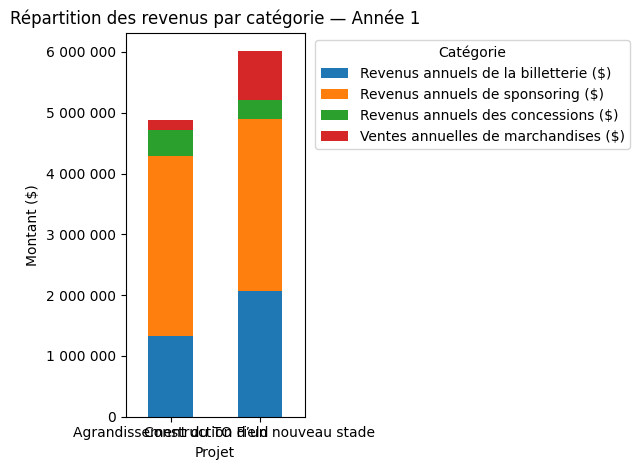

In [187]:
# Matrice catégories × projets pour l'Année 1
mat_y1 = pd.DataFrame({
    p: projets_revenus[p].loc["Année 1", colonnes_revenus].values
    for p in projets
}, index=colonnes_revenus)

plt.figure()
mat_y1.T.plot(kind="bar", stacked=True)
plt.title("Répartition des revenus par catégorie — Année 1")
plt.xlabel("Projet")
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.legend(title="Catégorie", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


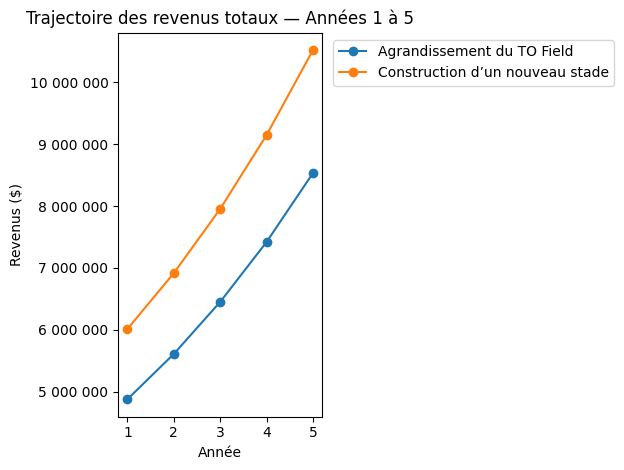

In [188]:
plt.figure()
xs = [1,2,3,4,5]
for p in projets:
    plt.plot(xs, rev_tot.loc[p, [f"Année {i}" for i in xs]], marker="o", label=p)

plt.title("Trajectoire des revenus totaux — Années 1 à 5")
plt.xlabel("Année")
plt.ylabel("Revenus ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(xs)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


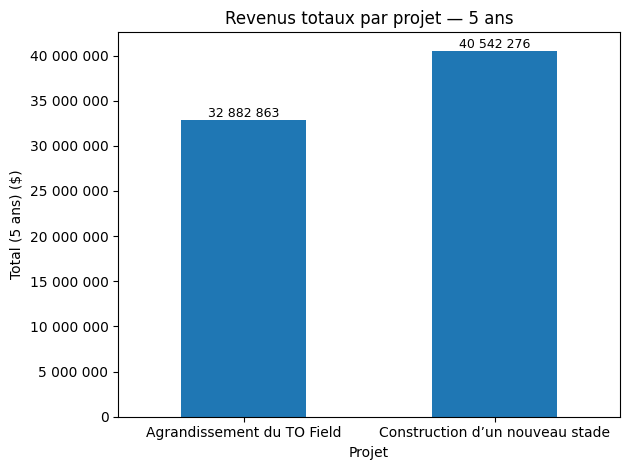

In [189]:
plt.figure()
ax = rev_tot["Total (5 ans)"].plot(kind="bar")
plt.title("Revenus totaux par projet — 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# étiquettes au-dessus des barres
vals = rev_tot["Total (5 ans)"].values
for i, v in enumerate(vals):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


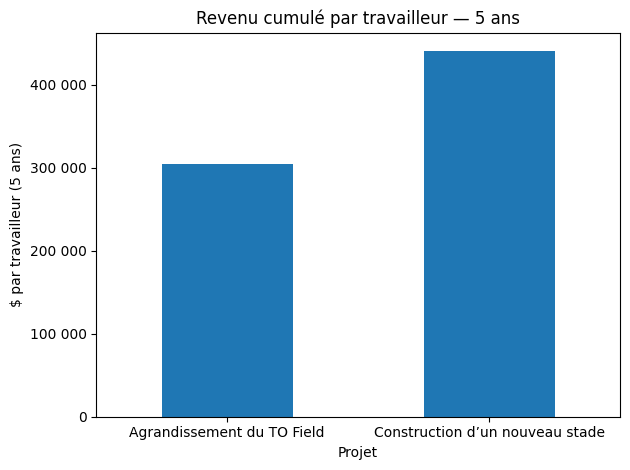

In [190]:
# Nécessite df_salaire_projet avec index = projets et col "Nombre de travailleurs"
try:
    df_aux = rev_tot[["Total (5 ans)"]].merge(
        df_salaire_projet[["Nombre de travailleurs"]],
        left_index=True, right_index=True, how="left"
    )
    df_aux["Revenu par travailleur (5 ans)"] = df_aux["Total (5 ans)"] / df_aux["Nombre de travailleurs"]

    plt.figure()
    df_aux["Revenu par travailleur (5 ans)"].plot(kind="bar")
    plt.title("Revenu cumulé par travailleur — 5 ans")
    plt.xlabel("Projet")
    plt.ylabel("$ par travailleur (5 ans)")
    plt.gca().yaxis.set_major_formatter(_fmt)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Info: visuel 6.4 ignoré (df_salaire_projet manquant ou index non aligné). Détail:", e)


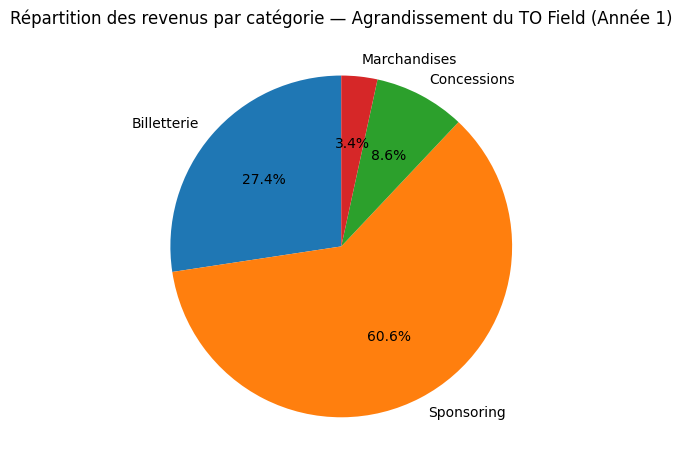

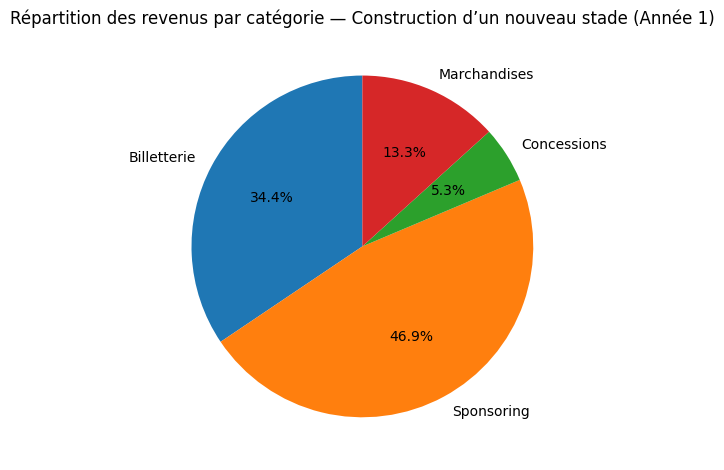

In [192]:
import matplotlib.pyplot as plt

# Sécurité : colonnes des catégories si besoin
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Un camembert par projet (une figure par projet, pratique pour le deck)
for projet, dfp in projets_revenus.items():
    valeurs = dfp.loc["Année 1", colonnes_revenus].values
    labels  = [
        "Billetterie",
        "Sponsoring",
        "Concessions",
        "Marchandises",
    ]
    plt.figure()
    plt.pie(valeurs, labels=labels, autopct="%1.1f%%", startangle=90)
    plt.title(f"Répartition des revenus par catégorie — {projet} (Année 1)")
    plt.tight_layout()
    plt.show()
    # # Option (deck) : sauvegarder l'image
    # plt.savefig(f"repartition_revenus_{projet.replace(' ', '_')}_Y1.png", dpi=200, bbox_inches="tight")


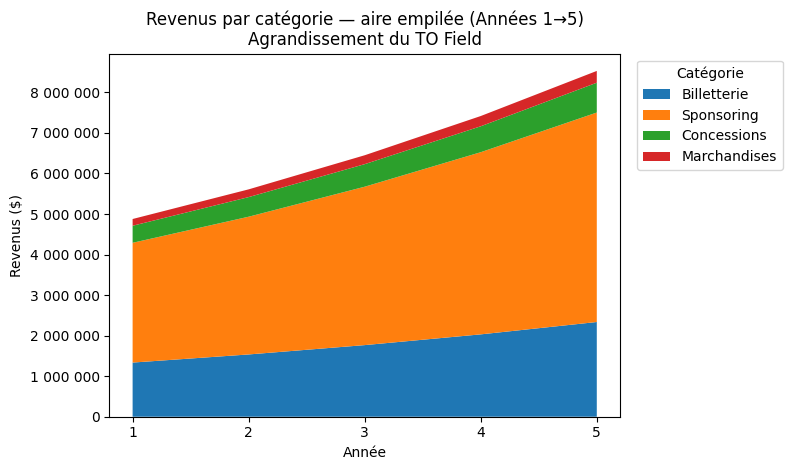

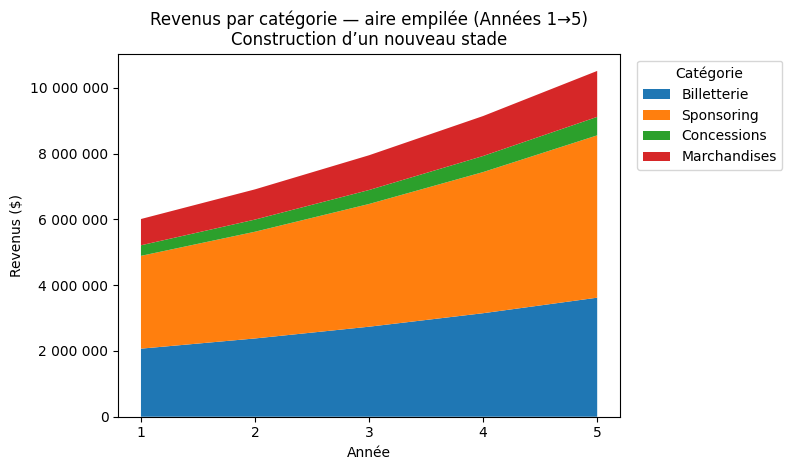

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Sécurité colonnes catégories
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Noms lisibles pour la légende
labels_cat = ["Billetterie", "Sponsoring", "Concessions", "Marchandises"]

# Formateur "milliers avec espaces" pour l'axe Y
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Tracer une aire empilée par projet
xs = [1, 2, 3, 4, 5]
for projet, dfp in projets_revenus.items():
    # Construire une matrice (catégorie × année)
    Y = np.vstack([
        [float(dfp.loc[f"Année {t}", col]) for t in xs]
        for col in colonnes_revenus
    ])

    plt.figure()
    plt.stackplot(xs, *Y, labels=labels_cat)
    plt.title(f"Revenus par catégorie — aire empilée (Années 1→5)\n{projet}")
    plt.xlabel("Année")
    plt.ylabel("Revenus ($)")
    plt.gca().yaxis.set_major_formatter(_fmt)
    plt.xticks(xs)
    plt.tight_layout()
    plt.legend(title="Catégorie", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()


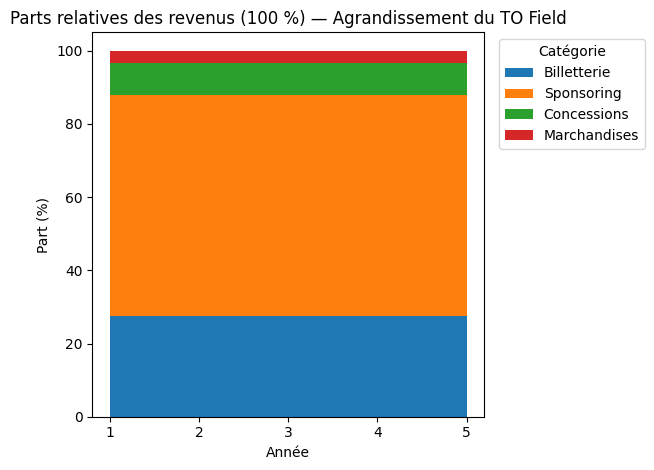

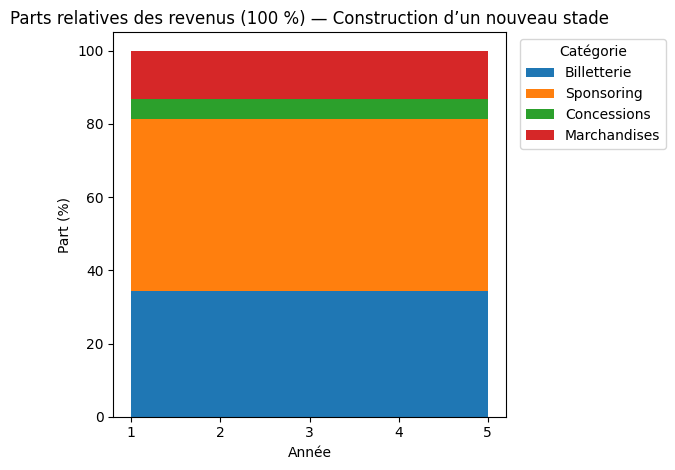

In [194]:
import numpy as np
import matplotlib.pyplot as plt

# Colonnes de catégories (au besoin)
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

labels_cat = ["Billetterie", "Sponsoring", "Concessions", "Marchandises"]
xs = [1, 2, 3, 4, 5]

for projet, dfp in projets_revenus.items():
    # Matrice bruts Y[cat, année]
    Y_abs = np.vstack([
        [float(dfp.loc[f"Année {t}", col]) for t in xs]
        for col in colonnes_revenus
    ])
    # Normalisation par colonne (année) -> pourcentages
    tot = Y_abs.sum(axis=0, keepdims=True)
    Y_pct = np.divide(Y_abs, tot, out=np.zeros_like(Y_abs), where=tot!=0) * 100.0

    plt.figure()
    plt.stackplot(xs, *Y_pct, labels=labels_cat)
    plt.title(f"Parts relatives des revenus (100 %) — {projet}")
    plt.xlabel("Année")
    plt.ylabel("Part (%)")
    plt.yticks([0,20,40,60,80,100])
    plt.xticks(xs)
    plt.legend(title="Catégorie", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


## Étape 7 — Introduction à la VAN

Nous allons maintenant calculer la **Valeur Actualisée Nette (VAN)**, un outil financier essentiel pour comparer les deux projets.

### Formule générale

$$
VAN = \sum_{t=0}^{N} \frac{CF_t}{(1+r)^t}
$$

Où :  
- $CF_t$ = **Cash Flow net à l’année t** (revenus – coûts, y compris les investissements initiaux)  
- $r$ = **taux d’actualisation** (ici 4 % selon la vue d’ensemble)  
- $N$ = durée de l’analyse (ici 5 ans)  

### Interprétation
- Le **Cash Flow net (CF)** est ce que le projet rapporte ou coûte réellement chaque année.  
- Le **taux d’actualisation (r)** reflète la valeur du temps : 1 $ aujourd’hui vaut plus que 1 $ dans 5 ans.  
- La division par $(1+r)^t$ réduit le poids des flux futurs : plus l’année est éloignée, moins elle compte.  
- En additionnant tous les flux actualisés, on obtient la **valeur présente nette du projet**.  

### Décision
- **VAN > 0** → le projet crée de la valeur (il rapporte plus qu’il ne coûte).  
- **VAN < 0** → le projet détruit de la valeur.  
- Entre deux projets, celui avec la **VAN la plus élevée** est généralement le choix recommandé.


In [137]:
import numpy as np
import pandas as pd

# --- Récupération des constantes (robuste : accepte VUEDENSEMBLE ou vue_d_ensemble) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

r = PARAMS["taux_actualisation"]
N = PARAMS["duree_analyse_ans"]

# --- Hypothèses explicites pour l’an 0 ---
# - Revenus à l’an 0 : 0 (les revenus commencent à l’Année 1)
# - Coûts de main-d’œuvre à l’an 0 : 0 (on ne compte que les années 1→5)
# - Coûts de construction à l’an 0 : pris depuis df_construction_proj["Année 0"]
#   (df_construction_proj doit déjà exister depuis l’Étape 5)
# - Projections Années 1→5 : déjà construites dans 5.x (coûts) et 6.x (revenus)

# --- 1) Revenus par projet et par année (1→5) ---
# Utilise les tableaux séparés créés en 6.1 : 'projets_revenus' (un DF par projet, lignes = "Année 1..5")
# et 'colonnes_revenus' = liste des 4 catégories de revenus.
# Si ces objets n’existent pas, lève une erreur explicite pour que tu saches quoi exécuter avant.
assert "projets_revenus" in globals(), "Exécute d'abord l'Étape 6.1 pour construire 'projets_revenus'."
assert "colonnes_revenus" in globals(), "Dans l'Étape 6.1, définis 'colonnes_revenus'."

# Tableau Revenus: index = projet, colonnes = Année 0..5 (0 sera à 0)
revenus_par_annee = pd.DataFrame(index=list(projets_revenus.keys()), columns=[f"Année {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)

for projet, df_proj in projets_revenus.items():
    for t in range(1, N+1):
        revenus_par_annee.loc[projet, f"Année {t}"] = df_proj.loc[f"Année {t}", colonnes_revenus].sum()

# --- 2) Coûts de main-d’œuvre par projet et par année (1→5) ---
# Utilise df_salaire_projet de l’Étape 4 (agrégé par projet) avec colonnes "Salaire annuel (année 1..5)"
assert "df_salaire_projet" in globals(), "Exécute l'Étape 4 (agrégation main-d'œuvre) avant de calculer la VAN."

couts_mo_par_annee = pd.DataFrame(index=df_salaire_projet.index, columns=[f"Année {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)
for t in range(1, N+1):
    couts_mo_par_annee[f"Année {t}"] = df_salaire_projet[f"Salaire annuel (année {t})"].astype(float)

# --- 3) Coûts de construction par projet et par année (0→5) ---
# Utilise df_construction_proj de l’Étape 5 (colonnes "Année 0..Année 5")
assert "df_construction_proj" in globals(), "Exécute l'Étape 5 (projection coûts de construction) avant de calculer la VAN."

couts_construction_par_annee = df_construction_proj[[f"Année {i}" for i in range(0, N+1)]].astype(float)

# --- 4) Cash flows nets (CF_t) : Revenus_t − (Coûts MO_t + Coûts Construction_t) ---
# Note: à l’an 0, revenus = 0 et coûts MO = 0 par hypothèse ; CF_0 = − Coûts Construction Année 0
projets = sorted(set(revenus_par_annee.index) | set(couts_mo_par_annee.index) | set(couts_construction_par_annee.index))
cf = pd.DataFrame(index=projets, columns=[f"Année {i}" for i in range(0, N+1)], dtype=float)

for p in projets:
    for t in range(0, N+1):
        rev = revenus_par_annee.loc[p, f"Année {t}"] if p in revenus_par_annee.index else 0.0
        mo  = couts_mo_par_annee.loc[p, f"Année {t}"] if p in couts_mo_par_annee.index else 0.0
        cap = couts_construction_par_annee.loc[p, f"Année {t}"] if p in couts_construction_par_annee.index else 0.0
        cf.loc[p, f"Année {t}"] = rev - (mo + cap)

# --- 5) VAN par projet ---
facteurs = np.array([(1 + r) ** t for t in range(0, N+1)])
van = (cf.values / facteurs).sum(axis=1)
df_van = pd.DataFrame({"VAN (sur 5 ans, r = {:.2%})".format(r): van}, index=cf.index)

# --- 6) Affichage (lisible) ---
from IPython.display import display
print("Taux d’actualisation (r) =", f"{r:.2%}")
print("\nCash flows nets par projet (Année 0 → Année 5) :")
display(cf)

print("\nVAN par projet :")
display(df_van)

# (Optionnel) Petite synthèse textuelle
p1, p2 = df_van.index.tolist()
diff_abs = df_van.iloc[1, 0] - df_van.iloc[0, 0]
diff_pct = diff_abs / abs(df_van.iloc[0, 0]) * 100 if df_van.iloc[0, 0] != 0 else np.nan
print(f"\nSynthèse : '{p2}' a une VAN supérieure de {diff_abs:,.2f} ({diff_pct:.2f} %) vs '{p1}'." .replace(",", " "))


Taux d’actualisation (r) = 4.00%

Cash flows nets par projet (Année 0 → Année 5) :


,Année 0,Année 1,Année 2,Année 3,Année 4,Année 5
Agrandissement du TO Field,-25 160 000.00,-9 787 176.00,-9 348 904.32,-8 806 764.93,-8 144 415.12,-7 343 045.56
Construction d’un nouveau stade,-343 497 000.00,-7 500 772.00,-6 869 090.94,-6 107 521.78,-5 195 878.60,-4 110 933.51



VAN par projet :


,"VAN (sur 5 ans, r = 4.00%)"
Agrandissement du TO Field,-64 040 844.05
Construction d’un nouveau stade,-370 310 052.59



Synthèse : 'Construction d’un nouveau stade' a une VAN supérieure de -306 269 208.54 (-478.24 %) vs 'Agrandissement du TO Field'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Récup taux actualisation
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS
r = PARAMS["taux_actualisation"]

# Axes lisibles (espaces)
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

projets = cf.index.tolist()
cols_annees = sorted(cf.columns, key=lambda s: int(s.split(" ")[1]))  # "Année 0..N"
xs = [int(c.split(" ")[1]) for c in cols_annees]


ModuleNotFoundError: No module named 'constants'

## Étape 8 — What-if analysis (sensibilités)

Objectif : tester des hypothèses alternatives pour comprendre les leviers qui font bouger la décision.

Nous allons procéder par sous-étapes :
- **8.1** — Retirer l’**achat du terrain** (Année 0) pour les deux options et recalculer la VAN.
- **8.2** — Varier le **taux de croissance des revenus** (ex. ±5 pts) et mesurer l’impact sur la VAN.
- **8.3** — Varier le **taux d’actualisation** (ex. 2 % ↔ 6 %) pour tester la sensibilité au coût du capital.
- (évent.) 8.x — Autres scénarios pertinents à ajouter si besoin (capacité, mix de revenus, etc.).

Chaque sous-étape = *Markdown bref* (hypothèse + logique) puis *code* (résultats + mini-synthèse).


## Étape 8.1 — Retirer l’achat du terrain (Année 0)

**Hypothèse testée.** On suppose que l’achat du terrain n’est **pas nécessaire** (ou est pris en charge autrement).  
**Mécanique.** On met à **0** la ligne **« Coût d’achat du terrain »** dans la feuille *Coûts de construction*, puis on **recalcule**:
- la projection des coûts de construction Année 0 → 5,
- les **cash flows** par année,
- la **VAN** pour chaque option.

**Intérêt.** Isoler l’effet du poste le plus capitalistique (le terrain) pour voir si le nouveau stade devient compétitif à horizon 5 ans.


In [145]:
# --- Sécurité : objets requis des étapes précédentes ---
assert "df_construction" in globals(),  "Étape 5 manquante : df_construction"
assert "df_construction_proj" in globals(), "Étape 5 manquante : df_construction_proj"
assert "df_salaire_projet" in globals(),    "Étape 4 manquante : df_salaire_projet"
assert "projets_revenus" in globals(),      "Étape 6.1 manquante : projets_revenus"

# --- Paramètres ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

taux_croissance = PARAMS["taux_croissance_couts"]
r = PARAMS["taux_actualisation"]
N = PARAMS["duree_analyse_ans"]

# Colonnes utilisées à l'étape 5
col_uniques = [
    "Coût d’achat du terrain",
    "Coûts de permis et d’inspection du site",
    "Coûts de préparation du site",
]
col_annuels = [
    "Coûts annuels d’entretien",
    "Coûts annuels de location d’équipement",
]
col_mensuels = [
    "Coûts mensuels de fournitures et matériaux",
    "Coûts mensuels des services publics",
    "Part mensuelle des revenus partagés avec les sponsors",
]

# --- (A) Recalcul des coûts de construction SANS achat du terrain ---
df_construction_sans_terrain = df_construction.copy()
if "Coût d’achat du terrain" in df_construction_sans_terrain.columns:
    df_construction_sans_terrain["Coût d’achat du terrain"] = 0.0

# Projection Année 0 → 5 (même logique que l'étape 5)
df_construction_sans_terrain_proj = pd.DataFrame(
    index=df_construction_sans_terrain["Option de projet d’infrastructure"].values
)

# Année 0 : coûts uniques (avec terrain = 0)
df_construction_sans_terrain_proj["Année 0"] = (
    df_construction_sans_terrain[col_uniques].sum(axis=1).astype(float).values
)

# Années 1 → 5 : annuels + 12×mensuels, avec croissance 2 %
for annee in range(1, N + 1):
    facteur = (1 + taux_croissance) ** (annee - 1)
    couts_annuels = df_construction_sans_terrain[col_annuels].sum(axis=1).astype(float).values * facteur
    couts_mensuels = df_construction_sans_terrain[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
    df_construction_sans_terrain_proj[f"Année {annee}"] = couts_annuels + couts_mensuels

# Harmoniser en float pour l'affichage
df_construction_sans_terrain_proj = df_construction_sans_terrain_proj.astype(float)

# --- (B) Recalcul des cash flows & VAN pour ce scénario ---
# Revenus par année (inchangés vs base)
revenus_par_annee = pd.DataFrame(
    index=list(projets_revenus.keys()),
    columns=[f"Année {i}" for i in range(0, N+1)],
    dtype=float
).fillna(0.0)

colonnes_revenus = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)"
]

for projet, df_proj in projets_revenus.items():
    for t in range(1, N+1):
        revenus_par_annee.loc[projet, f"Année {t}"] = df_proj.loc[f"Année {t}", colonnes_revenus].sum()

# Coûts main-d'œuvre (inchangés vs base)
couts_mo_par_annee = pd.DataFrame(
    index=df_salaire_projet.index,
    columns=[f"Année {i}" for i in range(0, N+1)],
    dtype=float
).fillna(0.0)

for t in range(1, N+1):
    couts_mo_par_annee[f"Année {t}"] = df_salaire_projet[f"Salaire annuel (année {t})"].astype(float)

# Coûts construction (scénario sans terrain)
couts_construction_par_annee_ST = df_construction_sans_terrain_proj[[f"Année {i}" for i in range(0, N+1)]].astype(float)

# Cash flows nets (scénario sans terrain)
projets = sorted(set(revenus_par_annee.index) | set(couts_mo_par_annee.index) | set(couts_construction_par_annee_ST.index))
cf_ST = pd.DataFrame(index=projets, columns=[f"Année {i}" for i in range(0, N+1)], dtype=float)

for p in projets:
    for t in range(0, N+1):
        rev = revenus_par_annee.loc[p, f"Année {t}"] if p in revenus_par_annee.index else 0.0
        mo  = couts_mo_par_annee.loc[p, f"Année {t}"] if p in couts_mo_par_annee.index else 0.0
        cap = couts_construction_par_annee_ST.loc[p, f"Année {t}"] if p in couts_construction_par_annee_ST.index else 0.0
        cf_ST.loc[p, f"Année {t}"] = rev - (mo + cap)

# VAN (scénario sans terrain)
facteurs = np.array([(1 + r) ** t for t in range(0, N+1)])
van_ST = (cf_ST.values / facteurs).sum(axis=1)
df_van_ST = pd.DataFrame({"VAN sans achat du terrain (r = {:.2%})".format(r): van_ST}, index=cf_ST.index)

# --- (C) Comparaison base vs scénario : VAN & variation ---
# On suppose que df_van (base) existe suite à l’Étape 7.1
assert "df_van" in globals(), "Exécute d’abord l’Étape 7.1 (VAN base) pour disposer de df_van."

df_van_compare = df_van.join(df_van_ST, how="inner")
df_van_compare["Δ VAN (abs)"] = df_van_compare.iloc[:,1] - df_van_compare.iloc[:,0]
df_van_compare["Δ VAN (%)"] = df_van_compare["Δ VAN (abs)"] / df_van_compare.iloc[:,0] * 100

from IPython.display import display
print("Coûts de construction — scénario SANS achat du terrain (aperçu) :")
display(df_construction_sans_terrain_proj)

print("\nCash flows nets — scénario SANS achat du terrain :")
display(cf_ST)

print("\nComparaison de VAN (base vs sans achat du terrain) :")
display(df_van_compare)

# Mini synthèse textuelle
for p in df_van_compare.index:
    base = df_van_compare.loc[p, df_van.columns[0]]
    st   = df_van_compare.loc[p, df_van_ST.columns[0]]
    dabs = df_van_compare.loc[p, "Δ VAN (abs)"]
    dpct = df_van_compare.loc[p, "Δ VAN (%)"]
    print(f"- {p} : VAN base = {base:,.2f} → VAN sans terrain = {st:,.2f} | Δ = {dabs:,.2f} ({dpct:.2f} %)".replace(",", " "))


Coûts de construction — scénario SANS achat du terrain (aperçu) :


,Année 0,Année 1,Année 2,Année 3,Année 4,Année 5
Agrandissement du TO Field,160 000.00,1 860 000.00,1 897 200.00,1 935 144.00,1 973 846.88,2 013 323.82
Construction d’un nouveau stade,497 000.00,2 665 000.00,2 718 300.00,2 772 666.00,2 828 119.32,2 884 681.71



Cash flows nets — scénario SANS achat du terrain :


,Année 0,Année 1,Année 2,Année 3,Année 4,Année 5
Agrandissement du TO Field,-160 000.00,-9 787 176.00,-9 348 904.32,-8 806 764.93,-8 144 415.12,-7 343 045.56
Construction d’un nouveau stade,-497 000.00,-7 500 772.00,-6 869 090.94,-6 107 521.78,-5 195 878.60,-4 110 933.51



Comparaison de VAN (base vs sans achat du terrain) :


,"VAN (sur 5 ans, r = 4.00%)",VAN sans achat du terrain (r = 4.00%),Δ VAN (abs),Δ VAN (%)
Agrandissement du TO Field,-64 040 844.05,-39 040 844.05,25 000 000.00,-39.04
Construction d’un nouveau stade,-370 310 052.59,-27 310 052.59,343 000 000.00,-92.63


- Agrandissement du TO Field : VAN base = -64 040 844.05 → VAN sans terrain = -39 040 844.05 | Δ = 25 000 000.00 (-39.04 %)
- Construction d’un nouveau stade : VAN base = -370 310 052.59 → VAN sans terrain = -27 310 052.59 | Δ = 343 000 000.00 (-92.63 %)


### 📒 Conclusion 8.1 — Scénario sans achat du terrain

Le test **« What if » sans achat du terrain** montre clairement l’impact majeur de ce poste de dépense initial :

* **Agrandissement du TO Field**

  * La VAN passe de **-64 M$** à **-39 M$**.
  * Amélioration de **25 M$**, soit environ **-39 % d’écart relatif**.
  * Cela confirme que l’achat du terrain représente une part non négligeable mais pas déterminante dans ce projet (l’essentiel du coût restant est lié à la main-d’œuvre et aux frais annuels/mensuels).

* **Construction d’un nouveau stade**

  * La VAN passe de **-370 M$** à **-27 M$**.
  * Amélioration énorme de **343 M$**, soit **-92 % d’écart relatif**.
  * Cela montre que l’achat du terrain est le facteur qui **plombe complètement la rentabilité du projet** sur 5 ans.
  * Sans ce coût initial massif, le projet devient bien plus compétitif face à l’agrandissement.

### Insight clé 💡

* L’**achat du terrain est le facteur décisif** :

  * Dans le cas du nouveau stade, il explique presque entièrement la différence de VAN par rapport à l’agrandissement.
  * Si le terrain est déjà possédé (ou offert par la ville/partenaires), alors le nouveau stade pourrait devenir un choix bien plus intéressant.

## Étape 8.2 — **Ajouter une Valeur Résiduelle (long terme)**

### Pourquoi c’est pertinent

* Un **stade** crée de la valeur **bien au-delà de 5 ans**.  
* Sans **valeur résiduelle (VR)**, on pénalise structurellement l’option « nouveau stade ».  
* La VR peut **inverser** ou **réduire** l’écart de VAN, car le nouveau stade profite d’un **horizon long**.  

### Idée simple

* On prend le **flux net** de l’**Année 5**, on suppose une **croissance à long terme** ($g$) (prudente, ex. 2 %), et on calcule une **VR type Gordon** :

$$
\text{VR}_5 = \frac{CF_6}{r - g} = \frac{CF_{5} \times (1+g)}{r - g}
$$

* Puis on **actualise** cette VR à aujourd’hui en la divisant par $((1+r)^5)$.


In [146]:
# Paramètre de croissance long terme (prudent)
g_long = 0.02  # 2%

# Recalcule la VAN en ajoutant une valeur résiduelle à l'année 5
df_van_VR = df_van.copy()
col_van = df_van.columns[0]

vr = {}
for p in cf.index:
    cf5 = cf.loc[p, "Année 5"]  # flux net année 5 (déjà revenus - MO - construction)
    VR5 = (cf5 * (1 + g_long)) / (r - g_long)  # valeur au temps t=5
    VR0 = VR5 / ((1 + r) ** 5)                  # actualisée à t=0
    van_avec_vr = df_van.loc[p, col_van] + VR0
    vr[p] = {"VAN (base)": df_van.loc[p, col_van], "Valeur résiduelle (VR0)": VR0, "VAN + VR": van_avec_vr}

df_van_VR = pd.DataFrame(vr).T
display(df_van_VR)


,VAN (base),Valeur résiduelle (VR0),VAN + VR
Agrandissement du TO Field,-64 040 844.05,-307 807 857.71,-371 848 701.76
Construction d’un nouveau stade,-370 310 052.59,-172 323 271.81,-542 633 324.39


Super 👍 tu viens d’obtenir le résultat de l’**Étape 8.2 (Valeur Résiduelle)**. On peut maintenant poser la conclusion.

---

## 📒 Conclusion 8.2 — Ajout de la Valeur Résiduelle (VR)

L’introduction d’une **valeur résiduelle (VR)** visait à refléter le fait qu’un stade garde une valeur économique au-delà de l’horizon de 5 ans.

### Résultats :

* **Agrandissement du TO Field** :

  * VAN (base) = **-64 M$**
  * VR actualisée = **-308 M$**
  * VAN + VR = **-372 M$**

* **Construction d’un nouveau stade** :

  * VAN (base) = **-370 M$**
  * VR actualisée = **-172 M$**
  * VAN + VR = **-543 M$**

### Interprétation :

* L’ajout de la VR **accentue encore l’écart négatif**, car les flux nets en année 5 sont **négatifs** dans les deux projets → la formule de Gordon extrapole donc cette perte indéfiniment.
* Le nouveau stade, pourtant censé être un projet de long terme, ressort même **plus défavorable** une fois la VR incluse.

### Insight clé 💡

* Ces résultats montrent que la **structure actuelle des cash flows** ne permet pas d’envisager une rentabilité, même à long terme.
* Autrement dit : **le problème n’est pas que l’horizon est trop court**, mais bien que les flux nets sont déficitaires chaque année.
* Pour redonner du sens au projet du nouveau stade, il faudrait **changer fondamentalement les hypothèses de revenus** (ex. capacité, billetterie, merchandising).


## Étape 8.3 — **Choc de capacité / prix (revenus de base)**

### Pourquoi c’est pertinent

* La **croissance %** homogène garde les **parts de revenus constantes** → peu d’enseignements.
* En revanche, un **uplift de capacité/prix** (billetterie) et un **uplift trafic** (concessions/merch) **dès l’Année 1** affecte **tous les flux futurs** → impact **massif** sur la VAN.

### Idée

* Appliquer des **multiplicateurs** de base **uniquement** au **nouveau stade** (ex. +30 % billetterie, +20 % concessions/merch), le sponsoring restant inchangé ou légèrement up (+5–10 %).

In [147]:
# Multiplicateurs d'uplift pour le NOUVEAU stade (à ajuster)
uplift = {
    "Revenus annuels de la billetterie ($)": 1.30,  # +30%
    "Revenus annuels de sponsoring ($)":     1.05,  # +5%
    "Revenus annuels des concessions ($)":   1.20,  # +20%
    "Ventes annuelles de marchandises ($)":  1.20,  # +20%
}

nom_nouveau = "Construction d’un nouveau stade"

# On clone les tableaux 6.1
projets_revenus_uplift = {}
for projet, dfp in projets_revenus.items():
    dfx = dfp.copy()
    if projet == nom_nouveau:
        # on multiplie les colonnes Année 1..5 catégorie par catégorie
        for col in dfx.columns:
            # on ne touche qu'aux colonnes de catégories (pas aux %)
            for k, mult in uplift.items():
                if col.startswith(k):  # ex. "Revenus annuels de la billetterie ($)"
                    dfx[col] = dfx[col] * mult
        # recalcule la ligne "Total (5 ans)" après uplift
        colonnes_revenus = [
            "Revenus annuels de la billetterie ($)",
            "Revenus annuels de sponsoring ($)",
            "Revenus annuels des concessions ($)",
            "Ventes annuelles de marchandises ($)"
        ]
        dfx.loc["Total (5 ans)", colonnes_revenus] = dfx.loc[[f"Année {i}" for i in range(1,6)], colonnes_revenus].sum()
    projets_revenus_uplift[projet] = dfx

# Recalcule des flux et de la VAN (même logique que 7.1) avec les nouveaux revenus
revenus_par_annee_u = pd.DataFrame(index=list(projets_revenus_uplift.keys()), columns=[f"Année {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)
for projet, dfp in projets_revenus_uplift.items():
    for t in range(1, N+1):
        revenus_par_annee_u.loc[projet, f"Année {t}"] = dfp.loc[f"Année {t}", colonnes_revenus].sum()

cf_u = cf.copy()
for p in cf_u.index:
    for t in range(1, N+1):
        mo  = couts_mo_par_annee.loc[p, f"Année {t}"]
        cap = couts_construction_par_annee.loc[p, f"Année {t}"]
        rev = revenus_par_annee_u.loc[p, f"Année {t}"]
        cf_u.loc[p, f"Année {t}"] = rev - (mo + cap)

van_u = (cf_u.values / np.array([(1 + r) ** t for t in range(0, N+1)])).sum(axis=1)
df_van_u = pd.DataFrame({"VAN (uplift base revenus)": van_u}, index=cf_u.index)

# Comparaison
df_van_comp = df_van.join(df_van_u, how="left")
df_van_comp["Δ VAN (abs)"] = df_van_comp["VAN (uplift base revenus)"] - df_van_comp[df_van.columns[0]]
display(df_van_comp)


,"VAN (sur 5 ans, r = 4.00%)",VAN (uplift base revenus),Δ VAN (abs)
Agrandissement du TO Field,-64 040 844.05,-64 040 844.05,0.00
Construction d’un nouveau stade,-370 310 052.59,-364 453 545.22,5 856 507.36


## 📒 Conclusion 8.3 — Uplift des revenus du nouveau stade

### Résultats

* **Agrandissement du TO Field** :

  * VAN reste inchangée : **-64 M$**.

* **Construction d’un nouveau stade** :

  * VAN de base : **-370 M$**
  * VAN avec uplift des revenus : **-364 M$**
  * Gain absolu : **+5,8 M$**

### Interprétation

* L’augmentation de la billetterie, du merchandising et des concessions améliore légèrement la VAN du **nouveau stade**.
* Mais l’amélioration est très marginale par rapport à l’écart total (5,8 M$ sur un déficit de plus de 360 M$).
* Cela confirme que même avec une hypothèse optimiste d’uplift des revenus, le **poids de l’investissement initial** reste trop élevé pour rattraper l’agrandissement sur un horizon de 5 ans.

### Insight clé 💡

* Ce test montre que **les revenus seuls ne suffisent pas à sauver le projet** dans un horizon court/moyen.
* L’option du **nouveau stade** ne devient compétitive que si :

  * l’achat du terrain est subventionné ou supprimé (comme on l’a vu à 8.1), **et**
  * les revenus connaissent un uplift fort et durable.

## Étape 9 — Scénarios long terme

Objectif : compléter l’analyse avec des horizons plus réalistes pour un actif d’infrastructure.

### Ce que nous testons
- **9.1** — Recalcul de la VAN sur **10 ans** et **20 ans** (mêmes hypothèses de croissance et de coûts).
- (optionnel) 9.2 — Cofinancement public/privé (réduction du CAPEX initial).
- (optionnel) 9.3 — Uplift structurel (capacité/prix) durable au-delà de 5 ans.
- (optionnel) 9.4 — Point de bascule (année à partir de laquelle le nouveau stade rattrape l’agrandissement).

### Pourquoi
Un horizon de 5 ans pénalise fortement la construction d’un nouveau stade (CAPEX massif).  
Allonger l’horizon permet d’observer si les **revenus récurrents** finissent par compenser le CAPEX initial.


In [157]:
import numpy as np
import pandas as pd
from IPython.display import display

# --- Paramètres (on lit depuis constants, comme avant) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

r  = PARAMS["taux_actualisation"]
gc = PARAMS["taux_croissance_couts"]
gr = PARAMS["taux_croissance_revenus"]

# Colonnes utilisées pour la reconstruction (noms déjà vus aux étapes 5/6)
col_uniques = [
    "Coût d’achat du terrain",
    "Coûts de permis et d’inspection du site",
    "Coûts de préparation du site",
]
col_annuels = [
    "Coûts annuels d’entretien",
    "Coûts annuels de location d’équipement",
]
col_mensuels = [
    "Coûts mensuels de fournitures et matériaux",
    "Coûts mensuels des services publics",
    "Part mensuelle des revenus partagés avec les sponsors",
]
colonnes_revenus_cat = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)",
]

# --- Helpers ---
def projeter_construction(df_construction_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection coûts de construction 0..N (coûts uniques en 0, annuels + 12*mensuels avec croissance gc ensuite)."""
    idx = df_construction_src["Option de projet d’infrastructure"].values
    out = pd.DataFrame(index=idx)
    # Année 0 = somme des coûts uniques
    out["Année 0"] = df_construction_src[col_uniques].sum(axis=1).astype(float).values
    # Années 1..N
    for t in range(1, N + 1):
        facteur = (1 + gc) ** (t - 1)
        a = df_construction_src[col_annuels].sum(axis=1).astype(float).values * facteur
        m = df_construction_src[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
        out[f"Année {t}"] = a + m
    return out.astype(float)

def projeter_main_oeuvre(df_main_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection des salaires par projet (somme) 1..N, à partir de 'Salaire annuel (année 1)' + croissance gc."""
    # On reconstruit depuis df_main (qui contient toutes les lignes individuelles)
    if "Salaire annuel (année 1)" not in df_main_src.columns:
        raise ValueError("df_main doit contenir 'Salaire annuel (année 1)' calculé à l'étape 2.")
    # Projeter par ligne
    base = df_main_src[["Option de projet d’infrastructure", "Salaire annuel (année 1)"]].copy()
    # Construire les colonnes projetées
    for t in range(2, N + 1):
        base[f"Salaire annuel (année {t})"] = base["Salaire annuel (année 1)"] * (1 + gc) ** (t - 1)
    # Agréger par projet
    agg = base.groupby("Option de projet d’infrastructure").sum(numeric_only=True)
    # Ajouter année 0 (0 par hypothèse pour la MO)
    agg.insert(0, "Année 0", 0.0)
    # Renommer les colonnes en Année t
    cols_map = {"Salaire annuel (année 1)": "Année 1"}
    cols_map.update({f"Salaire annuel (année {t})": f"Année {t}" for t in range(2, N + 1)})
    agg = agg.rename(columns=cols_map)
    # S'assurer que toutes les colonnes Année 0..N existent
    for t in range(0, N + 1):
        col = f"Année {t}"
        if col not in agg.columns:
            agg[col] = 0.0
    return agg[[f"Année {t}" for t in range(0, N + 1)]].astype(float)

def projeter_revenus(df_revenus_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection des revenus totaux par projet 1..N à partir des bases par catégorie + croissance gr."""
    idx = df_revenus_src["Option de projet d’infrastructure"].values
    out = pd.DataFrame(index=idx, columns=[f"Année {t}" for t in range(0, N + 1)], dtype=float).fillna(0.0)
    # Pour chaque projet, somme catégories * (1+gr)^(t-1)
    for _, row in df_revenus_src.iterrows():
        p = row["Option de projet d’infrastructure"]
        for t in range(1, N + 1):
            total_t = 0.0
            for c in colonnes_revenus_cat:
                total_t += float(row[c]) * (1 + gr) ** (t - 1)
            out.loc[p, f"Année {t}"] = total_t
    return out.astype(float)

def calculer_cf_et_van(N: int):
    """Construit CF 0..N et VAN pour chaque projet, en reconstruisant tout depuis les tables brutes."""
    # 1) Projections
    cons = projeter_construction(df_construction, N)
    mo   = projeter_main_oeuvre(df_main, N)
    rev  = projeter_revenus(df_revenus, N)
    # 2) CF = Revenus - (MO + Construction)
    projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
    cf = pd.DataFrame(index=projets, columns=[f"Année {t}" for t in range(0, N + 1)], dtype=float)
    for p in projets:
        for t in range(0, N + 1):
            rv = rev.loc[p, f"Année {t}"] if p in rev.index else 0.0
            mm = mo.loc[p, f"Année {t}"] if p in mo.index else 0.0
            cc = cons.loc[p, f"Année {t}"] if p in cons.index else 0.0
            cf.loc[p, f"Année {t}"] = rv - (mm + cc)
    # 3) VAN
    facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
    van_vals = (cf.values / facteurs).sum(axis=1)
    df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
    return cf, df_van_N

# --- Exécution : VAN 10 ans, 20 ans, 30 ans et 40 ans (sans rien modifier aux blocs précédents) ---
N_list = [10, 20, 30, 40]
resultats_van = []

for N in N_list:
    cf_N, df_van_N = calculer_cf_et_van(N)
    # print(f"\nCash flows nets (Année 0 → Année {N}) — horizon {N} ans :")
    # display(cf_N)
    print(f"\nVAN — horizon {N} ans :")
    display(df_van_N)
    resultats_van.append(df_van_N)

# Petit tableau récapitulatif côte à côte
df_van_10_20_30_40 = pd.concat(resultats_van, axis=1)
print("\nSynthèse VAN (10 ans vs 20 ans vs 30 ans vs 40 ans) :")
display(df_van_10_20_30_40)



VAN — horizon 10 ans :


,"VAN (10 ans, r = 4.00%)"
Agrandissement du TO Field,-77 728 093.26
Construction d’un nouveau stade,-368 015 710.38



VAN — horizon 20 ans :


,"VAN (20 ans, r = 4.00%)"
Agrandissement du TO Field,25 703 869.65
Construction d’un nouveau stade,-207 308 781.66



VAN — horizon 30 ans :


,"VAN (30 ans, r = 4.00%)"
Agrandissement du TO Field,511 877 915.46
Construction d’un nouveau stade,419 436 006.97



VAN — horizon 40 ans :


,"VAN (40 ans, r = 4.00%)"
Agrandissement du TO Field,2 008 184 691.22
Construction d’un nouveau stade,2 286 781 149.82



Synthèse VAN (10 ans vs 20 ans vs 30 ans vs 40 ans) :


,"VAN (10 ans, r = 4.00%)","VAN (20 ans, r = 4.00%)","VAN (30 ans, r = 4.00%)","VAN (40 ans, r = 4.00%)"
Agrandissement du TO Field,-77 728 093.26,25 703 869.65,511 877 915.46,2 008 184 691.22
Construction d’un nouveau stade,-368 015 710.38,-207 308 781.66,419 436 006.97,2 286 781 149.82


## 📒 Conclusion 9.1 — Horizons long terme

* **À 10 ans** : les deux projets restent **négatifs** (Agrand. ≈ **−77,7 M$**, Nouveau stade ≈ **−368,0 M$**).
* **À 20 ans** : l’**Agrandissement** devient **légèrement positif** (**+25,7 M$**) tandis que le **Nouveau stade** reste **négatif** (**−207,3 M$**).
* **À 30 ans** : les **deux** sont **positifs** (Agrand. **+511,9 M$**, Nouveau stade **+419,4 M$**), avec un avantage à l’agrandissement.
* **À 40 ans** : le **Nouveau stade** **dépasse** l’agrandissement (**+2,29 Md$** vs **+2,01 Md$**).

### Points de bascule (approx., interpolation linéaire)

* **Agrandissement** devient **VAN > 0** vers **~17,5 ans**.
* **Nouveau stade** devient **VAN > 0** vers **~23–24 ans**.
* **Croisement entre projets** (Nouveau stade > Agrand.) vers **~32–33 ans**.

👉 Lecture simple pour l’entretien :

* **Court/moyen terme (≤20 ans)** : agrandissement gagnant.
* **Très long terme (≥35 ans)** : le nouveau stade peut **créer plus de valeur** grâce aux revenus récurrents qui finissent par compenser le CAPEX massif.

## Étape 9.2 — Sensibilité au cofinancement (multi-horizons)

Objectif : mesurer l’effet d’un **cofinancement appliqué aux coûts uniques (Année 0)** du **nouveau stade** sur plusieurs horizons (10/20/30/40 ans).

Nous balayerons des paliers de cofinancement : **0 %, 10 %, 20 %, 30 %, 40 %, 50 %**  
Résultats :
1) **VAN du nouveau stade** selon le cofinancement et l’horizon.
2) **Écart de VAN** vs l’option **Agrandissement (base)**.
3) **Taux d’égalité** (approx.) par horizon, si le croisement existe.
4) Graphiques prêts à coller dans un deck.


,Cofinancement nouveau stade,VAN nouveau stade (30 ans),Δ vs agrandissement base (30 ans)
0,0%,419 436 006.97,-92 441 908.48
1,10%,453 785 706.97,-58 092 208.48
2,20%,488 135 406.97,-23 742 508.48
3,30%,522 485 106.97,10 607 191.52
4,40%,556 834 806.97,44 956 891.52
5,50%,591 184 506.97,79 306 591.52



≈ Taux de cofinancement d’égalité à 30 ans : 26.9% (approx.)


VAN du NOUVEAU stade (par cofinancement et horizon) :


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\3940355284.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_van_nouveau_form = tab_van_nouveau.applymap(fmt_spaces)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\3940355284.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_delta_form = tab_delta.applymap(fmt_spaces)


Horizon (ans),10,20,30,40
Cofinancement,,,,
0.00,-368 015 710.38,-207 308 781.66,419 436 006.97,2 286 781 149.82
0.10,-333 666 010.38,-172 959 081.66,453 785 706.97,2 321 130 849.82
0.20,-299 316 310.38,-138 609 381.66,488 135 406.97,2 355 480 549.82
0.30,-264 966 610.38,-104 259 681.66,522 485 106.97,2 389 830 249.82
0.40,-230 616 910.38,-69 909 981.66,556 834 806.97,2 424 179 949.82
0.50,-196 267 210.38,-35 560 281.66,591 184 506.97,2 458 529 649.82



Écart de VAN vs AGRANDISSEMENT (base) :


Horizon (ans),10,20,30,40
Cofinancement,,,,
0.00,-290 287 617.12,-233 012 651.31,-92 441 908.48,278 596 458.59
0.10,-255 937 917.12,-198 662 951.31,-58 092 208.48,312 946 158.59
0.20,-221 588 217.12,-164 313 251.31,-23 742 508.48,347 295 858.59
0.30,-187 238 517.12,-129 963 551.31,10 607 191.52,381 645 558.59
0.40,-152 888 817.12,-95 613 851.31,44 956 891.52,415 995 258.59
0.50,-118 539 117.12,-61 264 151.31,79 306 591.52,450 344 958.59



≈ Taux d’égalité (NOUVEAU stade = AGRANDISSEMENT base) :
- 10 ans : aucun croisement entre 0% et 50%
- 20 ans : aucun croisement entre 0% et 50%
- 30 ans : ~26.9% de cofinancement
- 40 ans : aucun croisement entre 0% et 50%


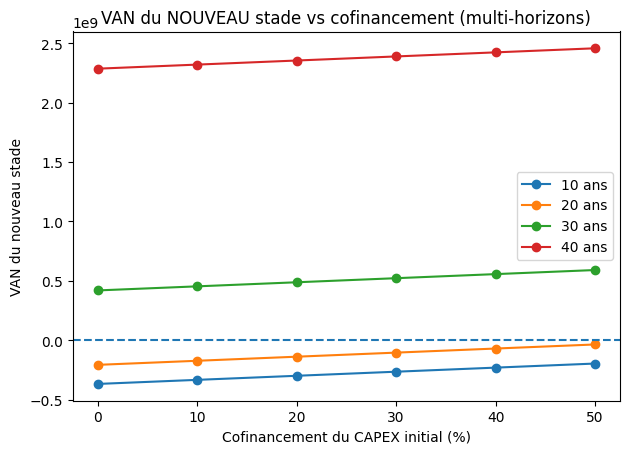

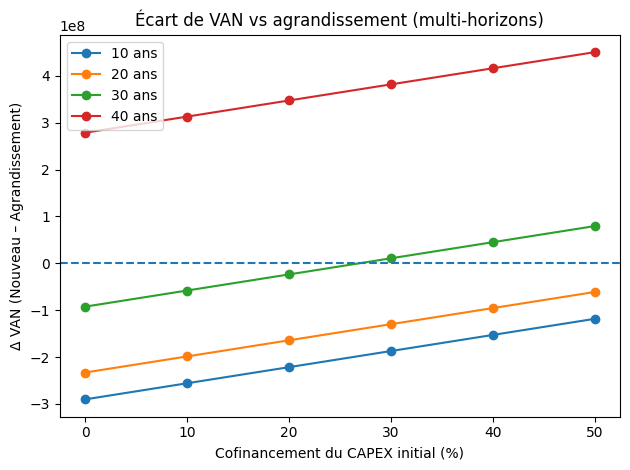

In [161]:
# ====== Paramètres ======
horizons = [10, 20, 30, 40]                          # Horizons testés
taux_list = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]      # Paliers de cofinancement
projet_nouveau = "Construction d’un nouveau stade"
projet_agrand  = "Agrandissement du TO Field"

# ====== Sécurité : fonctions présentes ? (patch minimal) ======
try:
    calculer_cf_et_van_depuis_tables
except NameError:
    # On suppose que 'r', 'projeter_construction', 'projeter_main_oeuvre', 'projeter_revenus' existent (9.1).
    # Si besoin, re-définis-les comme tu l’avais en 9.1.
    def calculer_cf_et_van_depuis_tables(df_construction_src, df_main_src, df_revenus_src, N: int):
        cons = projeter_construction(df_construction_src, N)
        mo   = projeter_main_oeuvre(df_main_src, N)
        rev  = projeter_revenus(df_revenus_src, N)
        projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
        cf = pd.DataFrame(index=projets, columns=[f"Année {t}" for t in range(0, N + 1)], dtype=float)
        for p in projets:
            for t in range(0, N + 1):
                rv = rev.loc[p, f"Année {t}"] if p in rev.index else 0.0
                mm = mo.loc[p, f"Année {t}"] if p in mo.index else 0.0
                cc = cons.loc[p, f"Année {t}"] if p in cons.index else 0.0
                cf.loc[p, f"Année {t}"] = rv - (mm + cc)
        facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
        van_vals = (cf.values / facteurs).sum(axis=1)
        df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
        return cf, df_van_N

# ====== 1) VAN base agrandissement par horizon ======
van_base_ag = {}
for N in horizons:
    _, vb = calculer_cf_et_van_depuis_tables(df_construction, df_main, df_revenus, N)
    van_base_ag[N] = float(vb.loc[projet_agrand].values[0])

# ====== 2) Balayage des paliers pour le NOUVEAU stade ======
col_uniques = [
    "Coût d’achat du terrain",
    "Coûts de permis et d’inspection du site",
    "Coûts de préparation du site",
]

rows = []
for N in horizons:
    for s in taux_list:
        df_construction_subv = df_construction.copy()
        mask = df_construction_subv["Option de projet d’infrastructure"] == projet_nouveau
        # Appliquer le cofinancement aux coûts uniques (Année 0) du nouveau stade
        for c in col_uniques:
            df_construction_subv.loc[mask, c] = df_construction_subv.loc[mask, c].astype(float) * (1 - s)

        _, van_subv = calculer_cf_et_van_depuis_tables(df_construction_subv, df_main, df_revenus, N)
        van_nouveau_subv = float(van_subv.loc[projet_nouveau].values[0])

        rows.append({
            "Horizon (ans)": N,
            "Cofinancement": s,
            "VAN nouveau stade": van_nouveau_subv,
            "Δ vs agrandissement (base)": van_nouveau_subv - van_base_ag[N],
        })

df_sweep_multi = pd.DataFrame(rows)

# ====== 3) Tableaux lisibles ======
def fmt_spaces(x):
    try:
        return f"{x:,.2f}".replace(",", " ")
    except:
        return x

# Table 3a — VAN du nouveau stade (lignes: cofinancement, colonnes: horizons)
tab_van_nouveau = df_sweep_multi.pivot(index="Cofinancement", columns="Horizon (ans)", values="VAN nouveau stade")
tab_van_nouveau_form = tab_van_nouveau.applymap(fmt_spaces)

# Table 3b — Δ vs agrandissement (idem)
tab_delta = df_sweep_multi.pivot(index="Cofinancement", columns="Horizon (ans)", values="Δ vs agrandissement (base)")
tab_delta_form = tab_delta.applymap(fmt_spaces)

print("VAN du NOUVEAU stade (par cofinancement et horizon) :")
display(tab_van_nouveau_form)
print("\nÉcart de VAN vs AGRANDISSEMENT (base) :")
display(tab_delta_form)

# ====== 4) Taux d’égalité approximatif par horizon (interpolation) ======
breakevens = {}
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    x = sub["Cofinancement"].values
    y = sub["Δ vs agrandissement (base)"].values  # on veut y == 0
    be = None
    for i in range(len(x)-1):
        if y[i] == 0:
            be = x[i]; break
        if (y[i] < 0 and y[i+1] > 0) or (y[i] > 0 and y[i+1] < 0):
            be = x[i] + (0 - y[i]) * (x[i+1] - x[i]) / (y[i+1] - y[i])
            break
    breakevens[N] = be

print("\n≈ Taux d’égalité (NOUVEAU stade = AGRANDISSEMENT base) :")
for N, be in breakevens.items():
    if be is None:
        print(f"- {N} ans : aucun croisement entre {int(taux_list[0]*100)}% et {int(taux_list[-1]*100)}%")
    else:
        print(f"- {N} ans : ~{be*100:.1f}% de cofinancement")

# ====== 5) Graphiques (prêts pour un deck) ======
import matplotlib.pyplot as plt

# Graphique A — VAN du NOUVEAU stade selon cofinancement (une courbe par horizon)
plt.figure()
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    plt.plot(sub["Cofinancement"]*100, sub["VAN nouveau stade"], marker="o", label=f"{N} ans")
plt.axhline(0, linestyle="--")
plt.xlabel("Cofinancement du CAPEX initial (%)")
plt.ylabel("VAN du nouveau stade")
plt.title("VAN du NOUVEAU stade vs cofinancement (multi-horizons)")
plt.legend()
plt.tight_layout()
plt.show()

# Graphique B — Δ VAN (NOUVEAU – AGRANDISSEMENT base) selon cofinancement
plt.figure()
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    plt.plot(sub["Cofinancement"]*100, sub["Δ vs agrandissement (base)"], marker="o", label=f"{N} ans")
plt.axhline(0, linestyle="--")
plt.xlabel("Cofinancement du CAPEX initial (%)")
plt.ylabel("Δ VAN (Nouveau – Agrandissement)")
plt.title("Écart de VAN vs agrandissement (multi-horizons)")
plt.legend()
plt.tight_layout()
plt.show()


## 📒 Conclusion 9.2 — Sensibilité au cofinancement (multi-horizons)

* **10 ans :** même avec **50 %** de cofinancement, le **nouveau stade** reste loin derrière l’**agrandissement** (Δ VAN ≈ **−119 M$**).
* **20 ans :** idem, **aucun** palier entre **0–50 %** ne suffit (Δ VAN ≈ **−233 M$ → −61 M$**).
* **30 ans :** **point d’égalité** atteint vers **~26.9 %** de cofinancement ; au-dessus de ce seuil, le **nouveau stade** dépasse l’agrandissement (ex. **+10,6 M$** à 30 %, **+45,0 M$** à 40 %).
* **40 ans :** le **nouveau stade** est **déjà supérieur sans cofinancement** (Δ VAN ≈ **+279 M$**), et l’avantage augmente fortement avec le cofinancement (jusqu’à **+450 M$** à 50 %).

### Lecture simple

* **≤ 20 ans :** agrandissement gagnant **quoi qu’il arrive** (dans la fourchette 0–50 %).
* **≈ 30 ans :** nouveau stade **défendable** si cofinancement **≥ ~27 %** des coûts initiaux.
* **40 ans :** nouveau stade **meilleur même sans cofinancement**.

## Étape 9.3 — Sensibilité au taux d’actualisation (multi-horizons)

**Objectif.** Mesurer l’impact du **taux d’actualisation r** sur la VAN des deux options, pour plusieurs horizons (10/20/30/40 ans).

**Hypothèses.**
- On conserve les croissances de coûts et de revenus (gc, gr) utilisées précédemment.
- On fait varier r dans {2 %, 3 %, 4 %, 5 %, 6 %}.
- Aucun changement aux revenus/capex de base (pas de cofinancement ici).

**Sorties.**
1) Tableau de VAN par **r** et **horizon**, pour chaque projet.
2) Graphique A : **VAN vs r** pour un horizon choisi (ex. 30 ans), **par projet**.
3) Graphique B : **Δ VAN (Nouveau – Agrandissement) vs r** pour le même horizon.

**Lecture.**
- Plus **r** augmente → plus la VAN baisse, surtout pour les projets avec des bénéfices lointains.
- Si la courbe du **nouveau stade** est plus sensible à r, c’est normal : ses gains sont plus tardifs.


VAN — AGRANDISSEMENT (par r et horizon) :


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\2048889148.py:117: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_ext = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_ext}").applymap(fmt_spaces)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\2048889148.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_new = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_new}").applymap(fmt_spaces)


Horizon (ans),10,20,30,40
r,,,,
0.02,-81 936 696.34,62 996 392.30,877 357 140.01,3 913 391 916.89
0.03,-79 767 676.96,42 537 752.49,670 751 418.84,2 797 716 211.58
0.04,-77 728 093.26,25 703 869.65,511 877 915.46,2 008 184 691.22
0.05,-75 808 178.53,11 847 135.93,389 283 697.37,1 446 231 243.43
0.06,-73 999 030.52,439 908.30,294 366 195.39,1 043 958 401.81



VAN — NOUVEAU STADE (par r et horizon) :


Horizon (ans),10,20,30,40
r,,,,
0.02,-368 732 694.33,-145 274 299.09,903 541 687.09,4 691 526 722.77
0.03,-368 380 572.71,-179 087 944.86,630 375 653.65,3 284 448 867.36
0.04,-368 015 710.38,-207 308 781.66,419 436 006.97,2 286 781 149.82
0.05,-367 641 463.38,-230 905 607.73,255 897 464.01,1 575 092 385.03
0.06,-367 260 689.82,-250 670 911.12,128 608 563.39,1 064 299 367.20


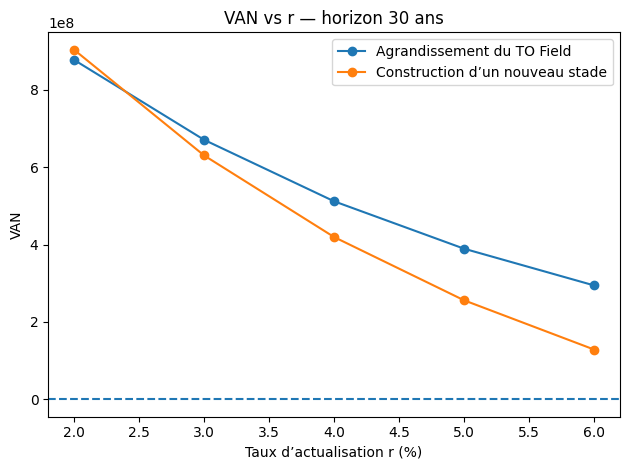

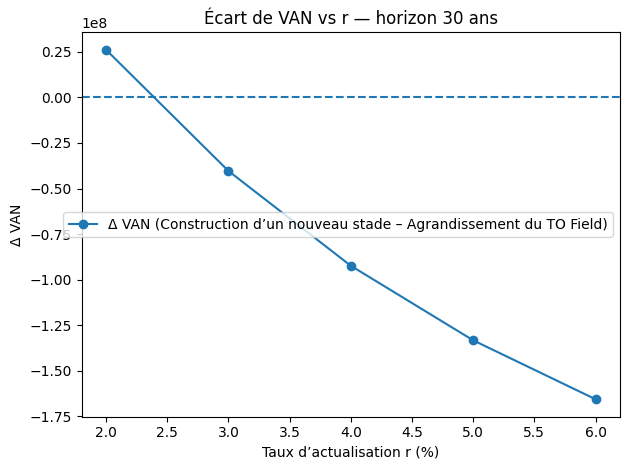

In [163]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# ---------------- Paramètres ----------------
r_list    = [0.02, 0.03, 0.04, 0.05, 0.06]   # taux d'actualisation testés
horizons  = [10, 20, 30, 40]                 # horizons testés
proj_new  = "Construction d’un nouveau stade"
proj_ext  = "Agrandissement du TO Field"
horizon_plot = 30                             # horizon utilisé pour les 2 graphiques
# --------------------------------------------

# --- Constants & paramètres de croissance (déjà utilisés plus tôt) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

gc = PARAMS["taux_croissance_couts"]      # croissance coûts
gr = PARAMS["taux_croissance_revenus"]    # croissance revenus

# Colonnes (conformes à tes feuilles Excel)
col_uniques = [
    "Coût d’achat du terrain",
    "Coûts de permis et d’inspection du site",
    "Coûts de préparation du site",
]
col_annuels = [
    "Coûts annuels d’entretien",
    "Coûts annuels de location d’équipement",
]
col_mensuels = [
    "Coûts mensuels de fournitures et matériaux",
    "Coûts mensuels des services publics",
    "Part mensuelle des revenus partagés avec les sponsors",
]
colonnes_revenus_cat = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)",
]

# --- Helpers (autonomes) ---
def projeter_construction(df_construction_src: pd.DataFrame, N: int) -> pd.DataFrame:
    idx = df_construction_src["Option de projet d’infrastructure"].values
    out = pd.DataFrame(index=idx)
    out["Année 0"] = df_construction_src[col_uniques].sum(axis=1).astype(float).values
    for t in range(1, N + 1):
        facteur = (1 + gc) ** (t - 1)
        a = df_construction_src[col_annuels].sum(axis=1).astype(float).values * facteur
        m = df_construction_src[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
        out[f"Année {t}"] = a + m
    return out.astype(float)

def projeter_main_oeuvre(df_main_src: pd.DataFrame, N: int) -> pd.DataFrame:
    if "Salaire annuel (année 1)" not in df_main_src.columns:
        raise ValueError("df_main doit contenir 'Salaire annuel (année 1)'.")
    base = df_main_src[["Option de projet d’infrastructure", "Salaire annuel (année 1)"]].copy()
    for t in range(2, N + 1):
        base[f"Salaire annuel (année {t})"] = base["Salaire annuel (année 1)"] * (1 + gc) ** (t - 1)
    agg = base.groupby("Option de projet d’infrastructure").sum(numeric_only=True)
    agg.insert(0, "Année 0", 0.0)
    ren = {"Salaire annuel (année 1)": "Année 1"} | {f"Salaire annuel (année {t})": f"Année {t}" for t in range(2, N + 1)}
    agg = agg.rename(columns=ren)
    for t in range(0, N + 1):
        col = f"Année {t}"
        if col not in agg.columns: agg[col] = 0.0
    return agg[[f"Année {t}" for t in range(0, N + 1)]].astype(float)

def projeter_revenus(df_revenus_src: pd.DataFrame, N: int) -> pd.DataFrame:
    idx = df_revenus_src["Option de projet d’infrastructure"].values
    out = pd.DataFrame(index=idx, columns=[f"Année {t}" for t in range(0, N + 1)], dtype=float).fillna(0.0)
    for _, row in df_revenus_src.iterrows():
        p = row["Option de projet d’infrastructure"]
        for t in range(1, N + 1):
            total_t = sum(float(row[c]) * (1 + gr) ** (t - 1) for c in colonnes_revenus_cat)
            out.loc[p, f"Année {t}"] = total_t
    return out.astype(float)

def calculer_cf_et_van_avec_r(df_construction_src, df_main_src, df_revenus_src, N: int, r: float):
    cons = projeter_construction(df_construction_src, N)
    mo   = projeter_main_oeuvre(df_main_src, N)
    rev  = projeter_revenus(df_revenus_src, N)
    projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
    cf = pd.DataFrame(index=projets, columns=[f"Année {t}" for t in range(0, N + 1)], dtype=float)
    for p in projets:
        for t in range(0, N + 1):
            rv = rev.loc[p, f"Année {t}"] if p in rev.index else 0.0
            mm = mo.loc[p, f"Année {t}"] if p in mo.index else 0.0
            cc = cons.loc[p, f"Année {t}"] if p in cons.index else 0.0
            cf.loc[p, f"Année {t}"] = rv - (mm + cc)
    facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
    van_vals = (cf.values / facteurs).sum(axis=1)
    df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
    return cf, df_van_N

# --- Boucle multi-r & multi-horizons ---
rows = []
for N in horizons:
    for r in r_list:
        _, vanN = calculer_cf_et_van_avec_r(df_construction, df_main, df_revenus, N, r)
        rows.append({
            "Horizon (ans)": N,
            "r": r,
            f"VAN {proj_ext}": float(vanN.loc[proj_ext].values[0]),
            f"VAN {proj_new}": float(vanN.loc[proj_new].values[0]),
        })
df_sens_r = pd.DataFrame(rows)

# --- Tables lisibles ---
def fmt_spaces(x):
    try: return f"{x:,.2f}".replace(",", " ")
    except: return x

tab_ext = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_ext}").applymap(fmt_spaces)
tab_new = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_new}").applymap(fmt_spaces)

print("VAN — AGRANDISSEMENT (par r et horizon) :")
display(tab_ext)
print("\nVAN — NOUVEAU STADE (par r et horizon) :")
display(tab_new)

# --- Graphiques (horizon choisi) ---
sub = df_sens_r[df_sens_r["Horizon (ans)"] == horizon_plot].sort_values("r")

plt.figure()
plt.plot(sub["r"]*100, sub[f"VAN {proj_ext}"], marker="o", label=proj_ext)
plt.plot(sub["r"]*100, sub[f"VAN {proj_new}"], marker="o", label=proj_new)
plt.axhline(0, linestyle="--")
plt.xlabel("Taux d’actualisation r (%)")
plt.ylabel("VAN")
plt.title(f"VAN vs r — horizon {horizon_plot} ans")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
delta = sub[f"VAN {proj_new}"] - sub[f"VAN {proj_ext}"]
plt.plot(sub["r"]*100, delta, marker="o", label=f"Δ VAN ({proj_new} – {proj_ext})")
plt.axhline(0, linestyle="--")
plt.xlabel("Taux d’actualisation r (%)")
plt.ylabel("Δ VAN")
plt.title(f"Écart de VAN vs r — horizon {horizon_plot} ans")
plt.legend()
plt.tight_layout()
plt.show()


## 📒 Conclusion 9.3 — Sensibilité au taux d’actualisation

* **Effet général :** quand le **taux d’actualisation (r)** augmente, la **VAN** diminue pour les deux projets. L’effet est **plus fort pour le nouveau stade**, car une plus grande part de sa valeur arrive tard (flux plus “back-loaded”).
* **10 ans :** VAN < 0 pour les deux projets, quel que soit r.
* **20 ans :** l’**agrandissement** devient positif pour tous les r testés (de justesse à 6 %) ; le **nouveau stade** reste négatif pour tous les r.
* **30 ans :** les **deux** sont positifs. Le **nouveau stade** n’est **meilleur** que pour un **r très faible (~2–2,5 %)** ; dès **r ≥ ~3 %**, l’**agrandissement** repasse devant.
* **40 ans :** le **nouveau stade** est **supérieur** à l’agrandissement **pour tous les r** testés.

**Lecture pour l’entretien :**

* À **horizon ≤ 30 ans** et **r “réaliste” (≥3 %) → agrandissement**.
* À **très long terme (≈40 ans)** ou avec un **r très bas (~2–2,5 %) → nouveau stade**.